In [1]:
import xml.etree.ElementTree as ET 
import gzip
from xml.etree.cElementTree import ElementTree

import pandas as pd
import geopandas as gpd
import timeit
import geopy.distance
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from shapely.geometry import Point, MultiPoint, Polygon
import random
from pyproj import Proj, transform #Convertion EPSG2154 to WGS84

from datetime import datetime

import statistics
from collections import defaultdict 

import matsim

In [2]:
## Adapted from Théo's code

def parse_attributes(node):
    values=[subnode.text for subnode in node.findall("attribute")]
    attributes=[subnode.attrib["name"] for subnode in node.findall("attribute")]
    person=dict()
    for ii in range(len(values)):
        person[attributes[ii]]=values[ii]
    if person!=[None]:
        return(person)
    
def parse_person(node):
    person = parse_attributes(node.find("attributes"))
    person["id"] = node.attrib["id"]
    return(person)

def parse_plan(node):
    children = list(node)
    plan={"selected":node.attrib["selected"]=="yes","activities":[{**{"activityType":child.tag}, **child.attrib} for child in children]}
    return plan

def parse_person_plan(node):
    # on récupère les plans sélectionnés
    plans = [parse_plan(plan) for plan in node.findall("plan") if plan.attrib["selected"]=="yes"]
    personId = node.attrib["id"]
    if len(plans)!=1:
        raise Exception("La personne d'id "+str(personId)+" a plusieurs plans sélectionnés !")
    else:
        plan={"personId":personId,"activities":plans[0]["activities"]}
        return(plan)

def parse_population(path):
    with gzip.open(initialPlanFile,'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        return [parse_person(node) for node in population.findall("person")]
    
def parse_plans_population(path):
    with gzip.open(initialPlanFile,'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        return [parse_person_plan(node) for node in population.findall("person")]

def select_first_coordinate_in_plan(person_plan):
    """A partir du plan d'une personne, remonte à ces premières coordonnées
    Renvoie un dict {personId,x,y}"""
    plan=person_plan["activities"]
    coordinates_found=False
    first_coordinates={"personId":person_plan["personId"]}
    for acti in plan:
        if "x" in acti:
            coordinates_found=True
            first_coordinates["x"]=acti["x"]
            first_coordinates["y"]=acti["y"]
            break
    if not coordinates_found:
        raise Exception("La personne "+str(person_plan["personId"])+" n'a pas de coordonnées définissables avec son plan d'activité.")
    else:
        return(first_coordinates)

def first_person_coordinates(path):
    with open(path, 'r') as fichier:
        tree = ET.ElementTree()
        tree.parse (fichier)
        population = tree.getroot()
        first_coordinates=[select_first_coordinate_in_plan(parse_person_plan(node)) for node in population.findall("person")]
        return(first_coordinates)

def population_stats(population):
    number=len(population)
    print("Taille population:   ",number)
    print("Titulaires du permis:",len([person for person in population if person["hasLicense"]=="yes"]))
    print("Femmes:              ",len([person for person in population if person["sex"]=="f"]))
    print("Hommes:              ",len([person for person in population if person["sex"]=="m"]))
    print("Revenu moyen:        ",statistics.mean([float(person["householdIncome"]) for person in population]))
    print("Abonnés aux pt:      ",len([person for person in population if person["hasPtSubscription"].lower()=="true"]))
    #return members
    #CSMembership(members,companies,CSMembership_file

In [3]:
def convert_time(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0])

def convert_time_h_m_s(x):
    return np.dot(np.array(x.split(":"), dtype = float), [3600.0, 60.0, 1.0])

## Scenario description : Shared autonomous vehicle (SAV) => Robotaxis
- Remplacement des voitures privées des individus par des robotaxis non partagés. 
- Démotorisation (surpression de la voiture) des ménages résidant dans des zones denses (Lyon, Villeurbanne, Bron, Vaulx-en-Velin et Caluire-et-Cuire)
- Un passager par taxi

## Description de la population

- $\mathbf{5\%}$ de la population réelle ($\mathbf{30900}$ ménages /$\mathbf{63 110}$ ind. / $\mathbf{310 000}$ dép.)
- Nombre de personnes motorisées dans les zones denses : 27073  pour  12148  menages.
- Nombre de personnes effectuant leurs déplacements en taxi  : 12779
- Nombre de taxis en tenant compte du menage (15%)  : 1822
- Nombre de taxis en tenant du nombre de déplacements en voiture par personne (15%)  : 1917
- Nombre total de déplacements en taxi : 36787
- Nombre de déplacements en taxi initialement prevus en VP-Conducteur : 28948
- Nombre de déplacements en taxi initialement prevus en VP-Passager : 7839
- Nombre de déplacements initialement prevus en VP-Conducteur maintenant à pied : 563
- Nombre de déplacements prevus en VP-Passager  maintenant à pied : 89
- Nombre de personnes non motorisées dans les zones denses : 11621  pour  8186  menages.
- Nombre de personnes motorisées dans les zones péripheriques : 21201  pour  8473  menages.
- Nombre de personnes non motorisées dans les zones péripheriques : 3275  pour  2216  menages.


In [4]:
12779*0.15, 12148 *0.15

(1916.85, 1822.2)

## Configuration de la simulation

- $\mathbf{2000}$ itérations / simulation (arret de l'innovation à $\mathbf{75\%}$)
- Strategies de re-planification :
    - $\mathbf{5}$ plans max / agent
    - Chaque agent change, avec une probalité de $\mathbf{5\%}$, son itinéraire et le planning de ses activités (heure de fin). La probabilité du changement du mode de transport a été fixée à $\mathbf{10\%}$ pour accelerer la convergernce de la simulation.
    - Le changement de modes de transport pour les agents situés dans les zones denses concernent uniquement les TC, le taxi, le vélo, et la marche à pied. Pour les agents zones peripheriques, le choix se fait entre la voiture, les TC, le vélo, et la marche à pied.
    - Chaque agent choisi un plan parmi les 5 selon un modèle logit avec une probalité de $\mathbf{80\%}$ durant la simulation.

In [5]:
### Trip distribution

In [6]:
output_path = "/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/scenario2_v2_15_p_cent_2000_ite" 

In [7]:
input_trips_file = "%s/df_trips_input_plans_sce2.csv" %output_path
input_persons_file = "%s/df_persons_input_perons_sce2.csv" %output_path
df_persons_input = pd.read_csv(input_persons_file)
df_trips_input = pd.read_csv(input_trips_file)

In [8]:
time_class = np.arange(0, 26) * 3600
df_trips_input["dep_time_in_s"] = df_trips_input["departure_time"].apply(convert_time_h_m_s).astype(float)
df_trips_input["dep_time_class"] = np.digitize(df_trips_input["dep_time_in_s"], time_class)
df_trips_input.loc[df_trips_input["dep_time_class"]==24, "dep_time_class"] = 0
df_trips_input.loc[df_trips_input["dep_time_class"]==25, "dep_time_class"] = 1
df_trips_input.loc[df_trips_input["dep_time_class"]==26, "dep_time_class"] = 2

In [9]:
f_taxi = df_trips_input["mode"] == "taxi"
df_trips_input_taxi = df_trips_input[f_taxi]
print("Nombre total de déplacements en taxi : ", len(df_trips_input_taxi) * 20)
print("Nombre total de déplacements en taxi : ", len(df_trips_input_taxi) * 20)
print("Nombre total de déplacements ponderé en taxi : ", len(df_trips_input_taxi) * 20)

Nombre total de déplacements en taxi :  735740
Nombre total de déplacements en taxi :  735740
Nombre total de déplacements ponderé en taxi :  735740


In [10]:
df_pond = pd.concat([df_trips_input_taxi]*20, ignore_index=True)
df_pond

,Unnamed: 0,person_id,departure_time,arrival_time,mode,preceding_purpose,from_x,from_y,preceding_purpose_start_time,preceding_purpose_end_time,following_purpose,to_x,to_y,following_purpose_start_time,following_purpose_end_time,is_first,is_last,dep_time_in_s,dep_time_class
0,0,1000008,07:03:47,07:13:47,taxi,home,844783.995555,6.519932e+06,NaN,07:03:47,other,842728.100000,6.519167e+06,07:13:47,07:13:47,True,False,25427.0,8
1,1,1000008,07:13:47,07:58:47,taxi,other,842728.100000,6.519167e+06,07:13:47,07:13:47,work,841768.160000,6.511899e+06,07:58:47,12:03:47,False,False,26027.0,8
2,4,1000008,17:33:47,18:18:47,taxi,work,841768.160000,6.511899e+06,12:43:47,17:33:47,home,844783.995555,6.519932e+06,18:18:47,19:28:47,False,False,63227.0,18
3,5,1000008,19:28:47,19:38:47,taxi,home,844783.995555,6.519932e+06,18:18:47,19:28:47,other,842067.600000,6.518710e+06,19:38:47,19:43:47,False,False,70127.0,20
4,6,1000008,19:43:47,19:53:47,taxi,other,842067.600000,6.518710e+06,19:38:47,19:43:47,home,844783.995555,6.519932e+06,19:53:47,NaN,False,True,71027.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735735,354511,999674,07:57:11,08:32:11,taxi,home,845450.080000,6.518884e+06,NaN,07:57:11,work,841840.120000,6.515749e+06,08:32:11,16:42:11,True,False,28631.0,8
735736,354512,999674,16:42:11,17:22:11,taxi,work,841840.120000,6.515749e+06,08:32:11,16:42:11,leisure,846659.700000,6.520819e+06,17:22:11,20:27:11,False,False,60131.0,17
735737,354513,999674,20:27:11,20:37:11,taxi,leisure,846659.700000,6.520819e+06,17:22:11,20:27:11,home,845450.080000,6.518884e+06,20:37:11,NaN,False,True,73631.0,21
735738,354538,999871,08:43:59,09:13:59,taxi,home,846557.250000,6.516266e+06,NaN,08:43:59,work,844019.770000,6.517061e+06,09:13:59,17:13:59,True,False,31439.0,9


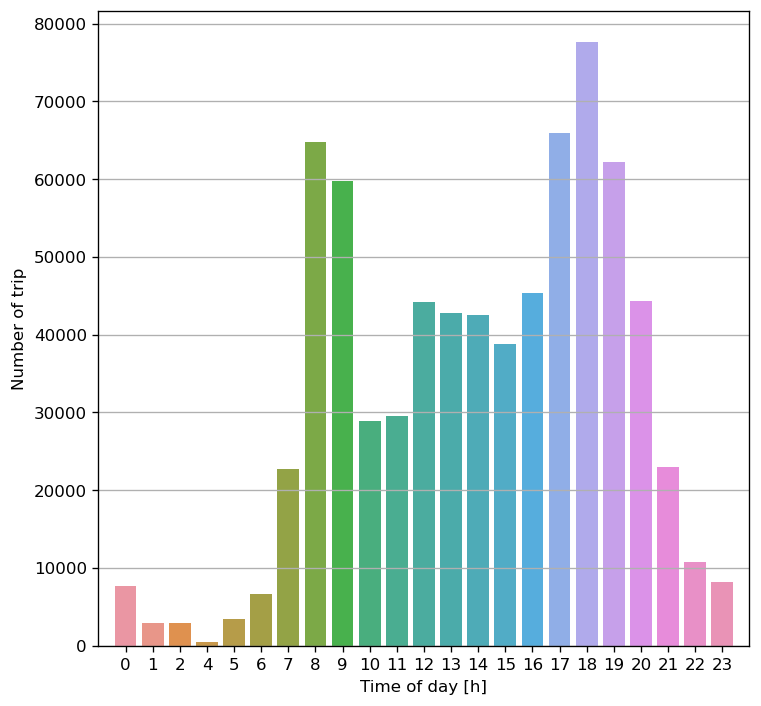

In [11]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_pond)
ax.grid(axis='y')
plt.xlim([-1, 23])
plt.ylabel("Number of trip")
plt.xlabel("Time of day [h]")
plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2_v2_15_p_cent/taxi_trip_distribution_sce2_weighted.pdf', bbox_inches="tight")

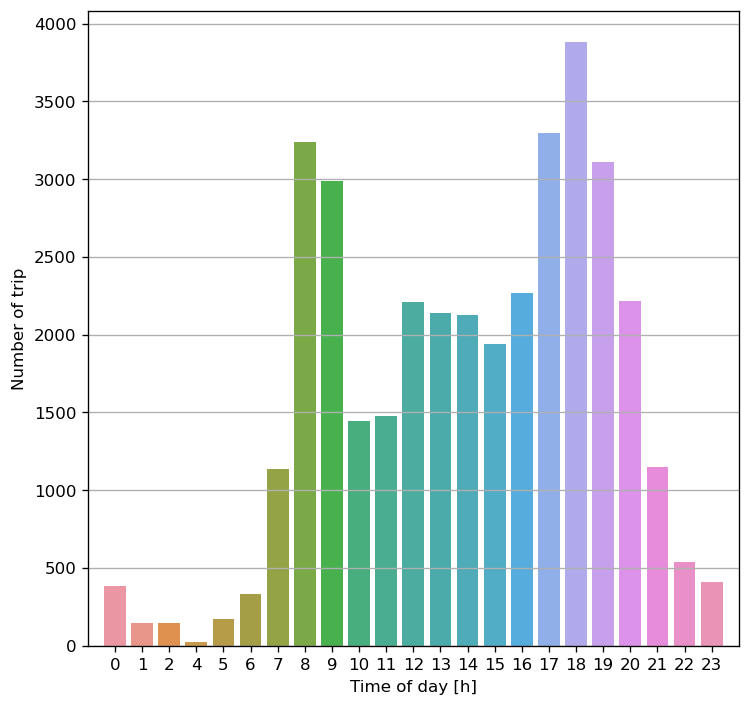

In [12]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_input_taxi)
ax.grid(axis='y')
plt.xlim([-1, 23])
plt.ylabel("Number of trip")
plt.xlabel("Time of day [h]")
plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2_v2_15_p_cent/taxi_trip_distribution_sce2.pdf', bbox_inches="tight")

## Analyse des resultats de la simulation

### Loading data

In [13]:
##Case 2 : with 1916 taxis
task_time_profiles_taxi_file = "%s/ITERS/it.2000/sce2.v2.2000.task_time_profiles_taxi.txt" %output_path
#task_time_profiles_taxi_file = "%s/sce2.v2.1200.task_time_profiles_taxi.txt" %output_path
df_task_time_profiles_taxi = pd.read_csv(task_time_profiles_taxi_file, sep="	")

In [14]:
df_task_time_profiles_taxi

,time,DROPOFF,EMPTY_DRIVE,OCCUPIED_DRIVE,PICKUP,STAY
0,00:00,0.0,0.0,0.0,0.0,1916.0
1,00:05,0.0,0.0,0.0,0.0,1916.0
2,00:10,0.0,0.0,0.0,0.0,1916.0
3,00:15,0.0,0.0,0.0,0.0,1916.0
4,00:20,0.0,0.0,0.0,0.0,1916.0
...,...,...,...,...,...,...
356,29:40,0.0,0.0,0.0,0.0,1916.0
357,29:45,0.0,0.0,0.0,0.0,1916.0
358,29:50,0.0,0.0,0.0,0.0,1916.0
359,29:55,0.0,0.0,0.0,0.0,1916.0


In [15]:
df_task_time_profiles_taxi["time_in_s"] = df_task_time_profiles_taxi["time"].apply(convert_time).astype(float)

In [16]:
df_task_time_profiles_taxi

,time,DROPOFF,EMPTY_DRIVE,OCCUPIED_DRIVE,PICKUP,STAY,time_in_s
0,00:00,0.0,0.0,0.0,0.0,1916.0,0.0
1,00:05,0.0,0.0,0.0,0.0,1916.0,300.0
2,00:10,0.0,0.0,0.0,0.0,1916.0,600.0
3,00:15,0.0,0.0,0.0,0.0,1916.0,900.0
4,00:20,0.0,0.0,0.0,0.0,1916.0,1200.0
...,...,...,...,...,...,...,...
356,29:40,0.0,0.0,0.0,0.0,1916.0,106800.0
357,29:45,0.0,0.0,0.0,0.0,1916.0,107100.0
358,29:50,0.0,0.0,0.0,0.0,1916.0,107400.0
359,29:55,0.0,0.0,0.0,0.0,1916.0,107700.0


In [17]:
hours = ["00:00","01:00","02:00","03:00","04:00","05:00","06:00","07:00","08:00","09:00","10:00","11:00", 
        "12:00","13:00","14:00","15:00","16:00","17:00","18:00","19:00","20:00","21:00","22:00","23:00","24:00",
        "25:00","26:00","27:00","28:00","29:00","30:00"]

In [18]:
df_task_time_profiles_taxi["BUSY"] = df_task_time_profiles_taxi["PICKUP"] + df_task_time_profiles_taxi["DROPOFF"] + df_task_time_profiles_taxi["EMPTY_DRIVE"] + df_task_time_profiles_taxi["OCCUPIED_DRIVE"]

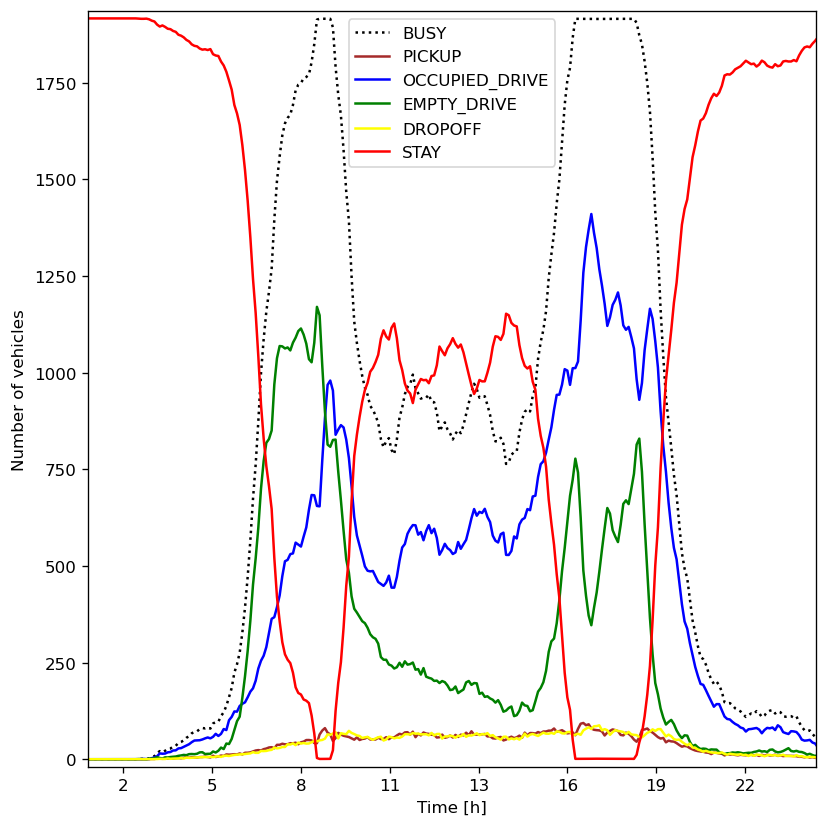

Fig. 1: Vehicle operations and open requests over the whole day with 1916 taxis


In [19]:
plt.figure(figsize = (7, 7), dpi = 120)

'''
for < in df_task_time_profiles_taxi.columns:
    if (str(col) == "time") or (str(col) == "time_h") or (str(col) == "time_in_s") :
        print("")
    
    else :
        plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi[col], color = (np.random.random_sample(), np.random.random_sample(), np.random.random_sample()), label = col)#, linestyle = ":")

'''
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["BUSY"], color = "black", label = "BUSY" , linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["PICKUP"], color = "brown", label = "PICKUP")#, linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["OCCUPIED_DRIVE"], color = "blue", label = "OCCUPIED_DRIVE")#, linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["EMPTY_DRIVE"], color = "green", label = "EMPTY_DRIVE")#, linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["DROPOFF"], color = "yellow", label = "DROPOFF")#, linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["STAY"], color = "red", label = "STAY")#, linestyle = ":")



plt.xlabel("Time [h]")
plt.ylabel("Number of vehicles")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([6000, 88000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2_v2_15_p_cent/task_time_profiles_Line_taxi_15_p_cent.pdf', bbox_inches="tight")
plt.close()
print("Fig. 1: Vehicle operations and open requests over the whole day with 1916 taxis")

In [20]:
print("Nombre maxi de taxis utilisés : ", int(max(df_task_time_profiles_taxi["BUSY"])))
print("Soit ", max(df_task_time_profiles_taxi["BUSY"])/1916 * 100, "% de la flotte.")

Nombre maxi de taxis utilisés :  1915
Soit  99.95824634655531 % de la flotte.


In [21]:
df_task_time_profiles_taxi["STAY_NORM"] = (df_task_time_profiles_taxi["STAY"] - df_task_time_profiles_taxi["STAY"].min()) / (df_task_time_profiles_taxi["STAY"].max() - df_task_time_profiles_taxi["STAY"].min())

In [22]:
df_task_time_profiles_taxi["STAY_NORM"]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
356    1.0
357    1.0
358    1.0
359    1.0
360    0.0
Name: STAY_NORM, Length: 361, dtype: float64

In [23]:
df_task_time_profiles_taxi_test = df_task_time_profiles_taxi.iloc[:24*12]

In [24]:
df_task_time_profiles_taxi_test

,time,DROPOFF,EMPTY_DRIVE,OCCUPIED_DRIVE,PICKUP,STAY,time_in_s,BUSY,STAY_NORM
0,00:00,0.000000,0.000000,0.000000,0.000000,1916.000000,0.0,0.000000,1.000000
1,00:05,0.000000,0.000000,0.000000,0.000000,1916.000000,300.0,0.000000,1.000000
2,00:10,0.000000,0.000000,0.000000,0.000000,1916.000000,600.0,0.000000,1.000000
3,00:15,0.000000,0.000000,0.000000,0.000000,1916.000000,900.0,0.000000,1.000000
4,00:20,0.000000,0.000000,0.000000,0.000000,1916.000000,1200.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...
283,23:35,8.560000,28.640000,65.363333,8.866667,1804.570000,84900.0,111.430000,0.941842
284,23:40,8.643333,21.360000,72.623333,8.726667,1804.646667,85200.0,111.353333,0.941882
285,23:45,7.170000,20.083333,72.000000,8.476667,1808.270000,85500.0,107.730000,0.943773
286,23:50,10.663333,21.813333,70.393333,7.996667,1805.133333,85800.0,110.866667,0.942136


In [25]:
24*12

288

In [26]:
df_task_time_profiles_taxi.to_csv("%s/df_task_time_profiles_taxi.csv" % output_path)

**Analyses**


La figure *Fig. 1* donne un aperçu la dynamique de répartition des taxis au cours de la journée pour une fotte de 3869 vehicules (taxis) :
- les véhicules roulant à vide vers les clients sont en vert, 
- ceux entrain de prendre des clients en marron, 
- en bleu, ce sont les taxis roulant avec des clients à bord
- les taxis déposant des clients sont en jaune
- ils totalisent tous le nombre de véhicules actuellement occupés (pointillés noirs)
- le nombre de demandes actuellement non planifiées (aucun véhicule n'a été envoyé vers elles) est indiqué en orange.

La figure illustre bien pics d'uttilisation des taxis durant les heures de pointes du matin (7h30h-9h) et du soir (17h-19h). 
On note une utilisation de **$75\%$** de la flotte pendant le pic du matin. Une grande partie de la flotte est donc mobilisée pour statisfaire la demande à cette periode.

Durant la pointe de l'après-midi, on observe une dimunition de nombre total de la flotte (moins de **$50\%$**). Cette baisse peut s'expliquer la reduction des distances à parcourir pour les trajets à vide sont. Cette situation est due probablement aux déplacments professionnels où les taxis sont utilisés le matin et parckés à proximité du lieu de travail.

## Daily statistics of taxis after the 1300th iteration

### Passenger Wait Time [s]

In [27]:
passenger_wait_time_file = "%s/ITERS/it.2000/passenger_wait_time.txt" %output_path
#passenger_wait_time_file = "%s/passenger_wait_time.txt" %output_path

In [28]:
df_passenger_wait_time = pd.read_csv(passenger_wait_time_file, sep="	")

In [29]:
df_passenger_wait_time

,hour,n,avg,sd,Unnamed: 4,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0
1,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0
2,2,0,0,0,NaN,0,0,0,0,0,0,0,0,0
3,3,30,"160,8","75,2",NaN,2,2,26,95,163,216,289,305,305
4,4,187,"162,6","96,2",NaN,2,2,6,92,151,220,350,389,497
5,5,415,"166,8","107,3",NaN,2,17,38,91,145,219,378,502,701
6,6,1446,"1065,9","1316,9",NaN,2,51,105,332,595,1179,3778,6039,8678
7,7,2440,"2095,8","2795,5",NaN,2,48,236,649,1102,2045,9044,12367,15926
8,8,2959,"1819,9","3952,9",NaN,2,2,76,418,787,1314,10220,19114,27338
9,9,2893,"345,7","365,9",NaN,2,2,2,96,237,467,1083,1481,2696


In [30]:
df_passenger_wait_time.drop('Unnamed: 4', inplace=True, axis=1)

In [31]:
df_passenger_wait_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hour    30 non-null     int64 
 1   n       30 non-null     int64 
 2   avg     30 non-null     object
 3   sd      30 non-null     object
 4   min     30 non-null     int64 
 5   2%ile   30 non-null     int64 
 6   5%ile   30 non-null     int64 
 7   25%ile  30 non-null     int64 
 8   50%ile  30 non-null     int64 
 9   75%ile  30 non-null     int64 
 10  95%ile  30 non-null     int64 
 11  98%ile  30 non-null     int64 
 12  max     30 non-null     int64 
dtypes: int64(11), object(2)
memory usage: 3.2+ KB


In [32]:
df_passenger_wait_time["avg"] = [str(i).replace(",", ".") for i in df_passenger_wait_time["avg"]]
df_passenger_wait_time["sd"] = [str(i).replace(",", ".") for i in df_passenger_wait_time["sd"]]

In [33]:
df_passenger_wait_time

,hour,n,avg,sd,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0
3,3,30,160.8,75.2,2,2,26,95,163,216,289,305,305
4,4,187,162.6,96.2,2,2,6,92,151,220,350,389,497
5,5,415,166.8,107.3,2,17,38,91,145,219,378,502,701
6,6,1446,1065.9,1316.9,2,51,105,332,595,1179,3778,6039,8678
7,7,2440,2095.8,2795.5,2,48,236,649,1102,2045,9044,12367,15926
8,8,2959,1819.9,3952.9,2,2,76,418,787,1314,10220,19114,27338
9,9,2893,345.7,365.9,2,2,2,96,237,467,1083,1481,2696


In [34]:
df_passenger_wait_time["avg"].unique()

array(['0', '160.8', '162.6', '166.8', '1065.9', '2095.8', '1819.9',
       '345.7', '94.5', '95.5', '106.9', '106.8', '106.4', '125.6',
       '453.1', '675.0', '706.4', '189.7', '98.3', '84.9', '103.5',
       '150.5', '148.5', '153.0', '106.6', '150.3', '98.6'], dtype=object)

In [35]:
df_passenger_wait_time["avg"] = df_passenger_wait_time["avg"].astype(float)

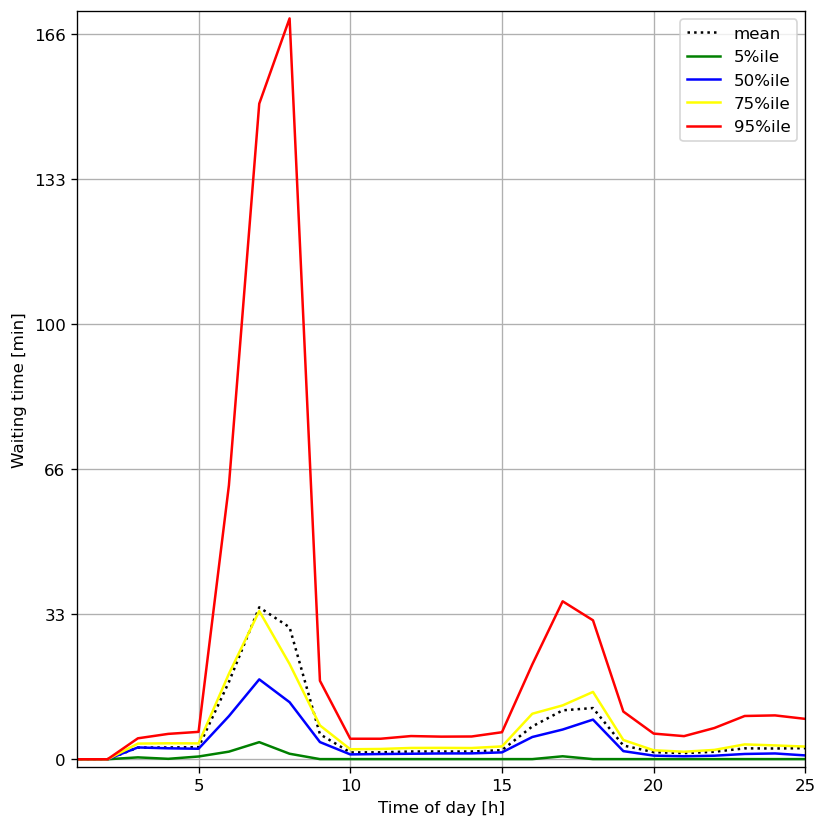

Fig. 2: Passenger wait times for each hour


In [36]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["avg"], color = "black", label = "mean", linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["5%ile"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["75%ile"], color = "yellow", label = "75%ile")#, linestyle = ":")
plt.plot(df_passenger_wait_time["hour"], df_passenger_wait_time["95%ile"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting time [min]")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/60)
))

plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2_v2_15_p_cent/passenger_wait_time_15_p_cent.pdf', bbox_inches="tight")
plt.close()
print("Fig. 2: Passenger wait times for each hour")

In [37]:
print("Max temp 95%ile d'attente ", max(df_passenger_wait_time["95%ile"])/60, " min")
print("Max temp 75%ile d'attente ", max(df_passenger_wait_time["75%ile"])/60, " min")
print("Max temp moyen d'attente ", max(df_passenger_wait_time["avg"])/60, " min")
print("Max temp median d'attente ", max(df_passenger_wait_time["50%ile"])/60, " min")
print("Max temp 5%ile d'attente ", max(df_passenger_wait_time["5%ile"])/60, " min")

Max temp 95%ile d'attente  170.33333333333334  min
Max temp 75%ile d'attente  34.083333333333336  min
Max temp moyen d'attente  34.93  min
Max temp median d'attente  18.366666666666667  min
Max temp 5%ile d'attente  3.933333333333333  min


**Analyses**


La figure *Fig. 2* les temps d'attente moyen (noir en pointillé), median (bleu), 5%ile (vert) et 95%ile (rouge) au cours de la journée pour une fotte de 3869 vehicules (taxis) :
- les temps d'attente moyens en dehors pic du matin matinal sont relativement faible (moins de 15 min). On note un maximal de 40 min durant les heures de pointes du matin. Le meme constat se fait pour les temps d'attente du 95e percentile où cette fois-ci le pic est de 2h30 d'attente. 
- le reste de la journée est assez stable avec des temps d'attente de moins de 3 min.

In [38]:
df_passenger_wait_time["avg_norm"] = (df_passenger_wait_time["avg"] - df_passenger_wait_time["avg"].min()) / (df_passenger_wait_time["avg"].max() - df_passenger_wait_time["avg"].min())

In [39]:
df_passenger_wait_time["avg_norm"]

0     0.000000
1     0.000000
2     0.000000
3     0.076725
4     0.077584
5     0.079588
6     0.508589
7     1.000000
8     0.868356
9     0.164949
10    0.045090
11    0.045567
12    0.051007
13    0.050959
14    0.050768
15    0.059929
16    0.216194
17    0.322073
18    0.337055
19    0.090514
20    0.046903
21    0.040510
22    0.049384
23    0.071810
24    0.070856
25    0.073003
26    0.050864
27    0.071715
28    0.047046
29    0.000000
Name: avg_norm, dtype: float64

In [40]:
df_passenger_wait_time["time_s"] = df_passenger_wait_time["hour"] * 3600

In [41]:
df_passenger_wait_time.to_csv("%s/df_passenger_wait_time.csv" % output_path)

## waiting time vs idle vehicles

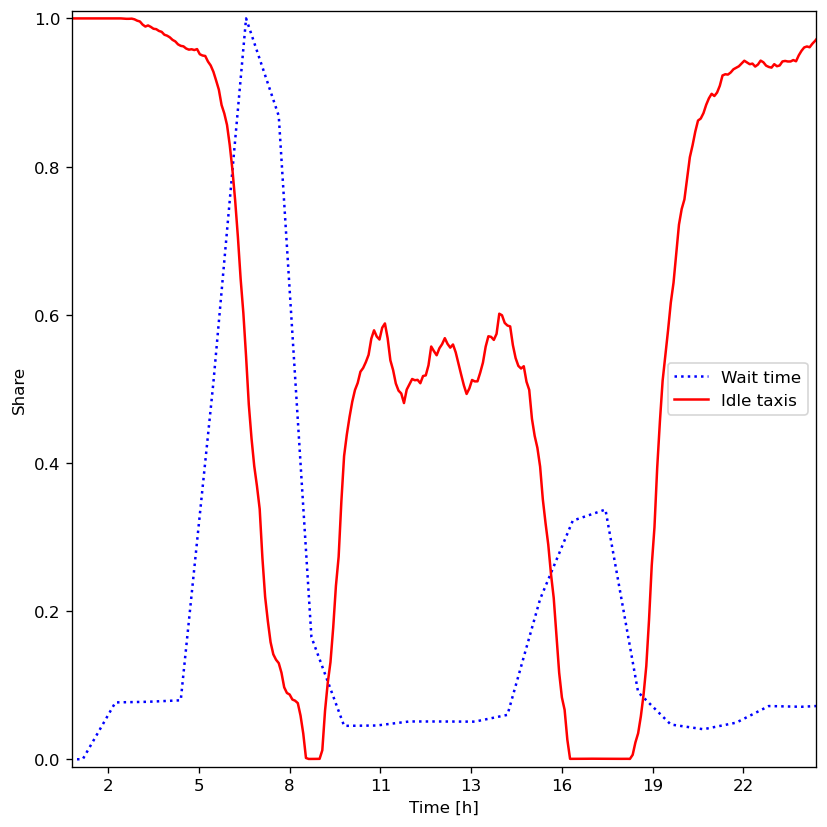

In [42]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_passenger_wait_time["time_s"], df_passenger_wait_time["avg_norm"], color = "blue", label = "Wait time", linestyle = ":")
plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi["STAY_NORM"], color = "red", label = "Idle taxis")#, linestyle = ":")



plt.xlabel("Time [h]")
plt.ylabel("Share")

plt.gca().xaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/3600)
))

#plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([6000, 88000])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2_v2_15_p_cent/wainting_time_vs_idle_taxis_15_p_cent.pdf', bbox_inches="tight")
plt.close()

### Vehicle Empty Drive Ratio

In [43]:
vehicle_empty_drive_ratio_file = "%s/ITERS/it.2000/vehicle_empty_drive_ratio.txt" %output_path
#vehicle_empty_drive_ratio_file = "%s/vehicle_empty_drive_ratio.txt" %output_path

In [44]:
df_vehicle_empty_drive_ratio = pd.read_csv(vehicle_empty_drive_ratio_file, sep="	")
df_vehicle_empty_drive_ratio

,hour,fleetAvg,avg,sd,Unnamed: 4,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0
1,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0
2,2,0,0,0,NaN,0,0,0,0,0,0,0,0,0
3,3,"0,3262","0,3924","0,2404",NaN,"0,077","0,077","0,079","0,208","0,311","0,559","0,928","1,000","1,000"
4,4,"0,2349","0,3236","0,2687",NaN,"0,000","0,000","0,000","0,143","0,239","0,420","1,000","1,000","1,000"
5,5,"0,2429","0,2881","0,2506",NaN,"0,000","0,000","0,000","0,130","0,233","0,341","1,000","1,000","1,000"
6,6,"0,5878","0,7161","0,3012",NaN,"0,000","0,076","0,167","0,465","0,788","1,000","1,000","1,000","1,000"
7,7,"0,7101","0,7515","0,2311",NaN,"0,000","0,312","0,360","0,565","0,753","1,000","1,000","1,000","1,000"
8,8,"0,6441","0,6622","0,2545",NaN,"0,000","0,196","0,274","0,463","0,632","1,000","1,000","1,000","1,000"
9,9,"0,4559","0,4257","0,3111",NaN,"0,000","0,012","0,056","0,187","0,333","0,582","1,000","1,000","1,000"


In [45]:
df_vehicle_empty_drive_ratio.drop('Unnamed: 4', inplace=True, axis=1)

In [46]:
df_vehicle_empty_drive_ratio["avg"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["avg"]]
df_vehicle_empty_drive_ratio["sd"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["sd"]]
df_vehicle_empty_drive_ratio["5%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["5%ile"]]
df_vehicle_empty_drive_ratio["50%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["50%ile"]]
df_vehicle_empty_drive_ratio["75%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["75%ile"]]
df_vehicle_empty_drive_ratio["95%ile"] = [str(i).replace(",", ".") for i in df_vehicle_empty_drive_ratio["95%ile"]]

df_vehicle_empty_drive_ratio["avg"] = df_vehicle_empty_drive_ratio["avg"].astype(float)
df_vehicle_empty_drive_ratio["5%ile"] = df_vehicle_empty_drive_ratio["5%ile"].astype(float)
df_vehicle_empty_drive_ratio["50%ile"] = df_vehicle_empty_drive_ratio["50%ile"].astype(float)
df_vehicle_empty_drive_ratio["75%ile"] = df_vehicle_empty_drive_ratio["75%ile"].astype(float)
df_vehicle_empty_drive_ratio["95%ile"] = df_vehicle_empty_drive_ratio["95%ile"].astype(float)

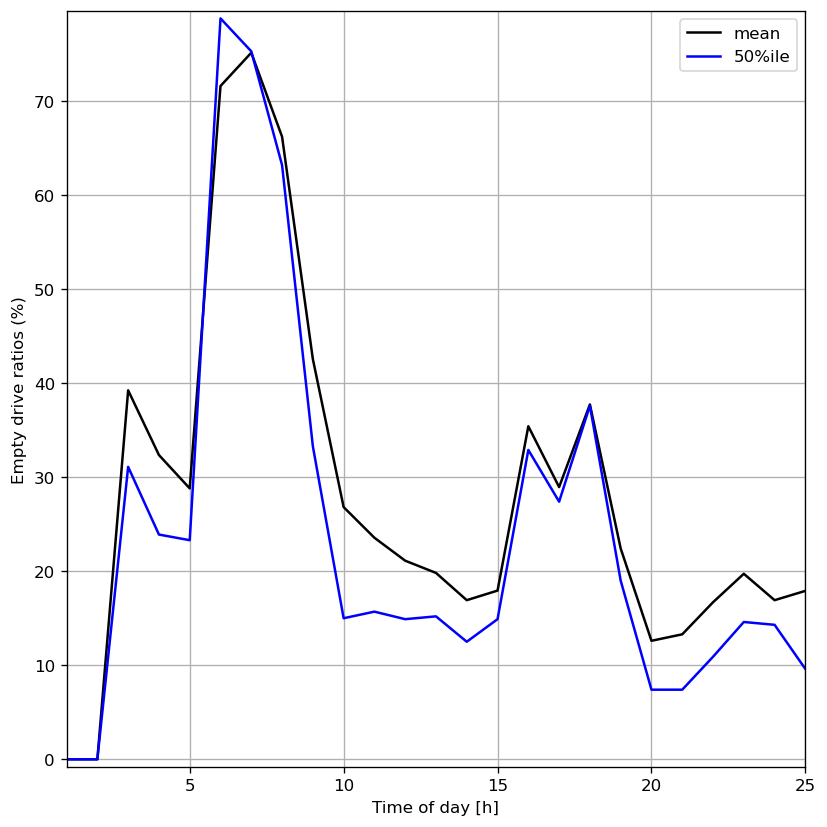

Fig. 3: Empty drive ratios for each hour


In [47]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["avg"], color = "black", label = "mean")
#plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["5%ile"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")
#plt.plot(df_vehicle_empty_drive_ratio["hour"], df_vehicle_empty_drive_ratio["95%ile"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Empty drive ratios (%)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x * 100)
))


plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2_v2_15_p_cent/vehicle_empty_drive_ratio_15_p_cent.pdf', bbox_inches="tight")
plt.close()
print("Fig. 3: Empty drive ratios for each hour")

**Analyses**


La figure *Fig. 3*  renseigne sur le rapport entre le temps de conduite à vide et le temps total consacré à la conduite.
Durant le pic du matin (6h-8h), le ratio est très important avec près de $80\%$ de la flotte en moyenne qui circule à vide. 
Le reste de la journée, ce ratio diminue avec $30\%$ à 10h et moins de $20\%$ à la deuxieme moitié de la journée.

### Vehicle Wait Ratio

In [48]:
vehicle_wait_ratio_file = "%s/ITERS/it.2000/vehicle_wait_ratio.txt" %output_path
#vehicle_wait_ratio_file = "%s/vehicle_wait_ratio.txt" %output_path
df_vehicle_wait_ratio = pd.read_csv(vehicle_wait_ratio_file, sep="	")
df_vehicle_wait_ratio

,hour,fleetAvg,avg,sd,Unnamed: 4,min,2%ile,5%ile,25%ile,50%ile,75%ile,95%ile,98%ile,max
0,0,"1,0000","1,0000","0,0000",NaN,"1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
1,1,"1,0000","1,0000","0,0000",NaN,"1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
2,2,"1,0000","1,0000","0,0000",NaN,"1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
3,3,"0,9976","0,9976","0,0236",NaN,"0,627","1,000","1,000","1,000","1,000","1,000","1,000","1,000","1,000"
4,4,"0,9791","0,9791","0,0903",NaN,"0,172","0,590","0,809","1,000","1,000","1,000","1,000","1,000","1,000"
5,5,"0,9538","0,9538","0,1360",NaN,"0,108","0,438","0,621","1,000","1,000","1,000","1,000","1,000","1,000"
6,6,"0,8077","0,8077","0,2832",NaN,"0,003","0,042","0,144","0,672","1,000","1,000","1,000","1,000","1,000"
7,7,"0,3057","0,3057","0,3625",NaN,"0,000","0,000","0,000","0,002","0,113","0,566","1,000","1,000","1,000"
8,8,"0,0710","0,0710","0,2045",NaN,"0,000","0,000","0,000","0,001","0,002","0,006","0,748","0,824","0,846"
9,9,"0,1122","0,1122","0,1361",NaN,"0,000","0,000","0,000","0,004","0,061","0,167","0,419","0,520","0,623"


In [49]:
df_vehicle_wait_ratio.drop('Unnamed: 4', inplace=True, axis=1)

In [50]:
df_vehicle_wait_ratio["avg"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["avg"]]
df_vehicle_wait_ratio["sd"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["sd"]]
df_vehicle_wait_ratio["5%ile"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["5%ile"]]
df_vehicle_wait_ratio["50%ile"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["50%ile"]]
df_vehicle_wait_ratio["95%ile"] = [str(i).replace(",", ".") for i in df_vehicle_wait_ratio["95%ile"]]

df_vehicle_wait_ratio["avg"] = df_vehicle_wait_ratio["avg"].astype(float)
df_vehicle_wait_ratio["5%ile"] = df_vehicle_wait_ratio["5%ile"].astype(float)
df_vehicle_wait_ratio["50%ile"] = df_vehicle_wait_ratio["50%ile"].astype(float)
df_vehicle_wait_ratio["95%ile"] = df_vehicle_wait_ratio["95%ile"].astype(float)

In [51]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["avg"], color = "black", label = "mean" , linestyle = ":")
#plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["5%ile"], color = "green", label = "5%ile")#, linestyle = ":")
plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")
#plt.plot(df_vehicle_wait_ratio["hour"], df_vehicle_wait_ratio["95%ile"], color = "red", label = "95%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting vehicles ratios (%)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x * 100)
))


plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
#plt.show()
plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2_v2_15_p_cent/vehicle_wait_ratio_15_p_cent.pdf', bbox_inches="tight")
plt.close()
print("Fig. 4: Waiting vehicles ratios ")

Fig. 4: Waiting vehicles ratios 


### Total duration of tasks by type [h]

In [52]:
duration_of_tasks_by_type_file = "%s/ITERS/it.2000/duration_of_tasks_by_type.txt" %output_path
#duration_of_tasks_by_type_file = "%s/duration_of_tasks_by_type.txt" %output_path
df_duration_of_tasks_by_type = pd.read_csv(duration_of_tasks_by_type_file, sep="	")
df_duration_of_tasks_by_type

,hour,EMPTY_DRIVE,PICKUP,OCCUPIED_DRIVE,DROPOFF,STAY,all
0,0,"0,00","0,00","0,00","0,00","1916,00","1916,00"
1,1,"0,00","0,00","0,00","0,00","1916,00","1916,00"
2,2,"0,00","0,00","0,00","0,00","1916,00","1916,00"
3,3,"1,31","0,47","2,70","0,21","1911,31","1916,00"
4,4,"8,16","2,95","26,56","2,34","1876,01","1916,00"
5,5,"18,44","6,55","57,49","6,01","1827,51","1916,00"
6,6,"200,03","15,33","140,25","12,82","1547,57","1916,00"
7,7,"903,14","31,91","368,64","26,49","585,81","1916,00"
8,8,"1089,72","45,79","602,04","42,42","136,03","1916,00"
9,9,"718,01","62,77","856,78","63,38","215,05","1916,00"


In [53]:
df_duration_of_tasks_by_type["EMPTY_DRIVE"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["EMPTY_DRIVE"]]
df_duration_of_tasks_by_type["PICKUP"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["PICKUP"]]
df_duration_of_tasks_by_type["OCCUPIED_DRIVE"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["OCCUPIED_DRIVE"]]
df_duration_of_tasks_by_type["DROPOFF"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["DROPOFF"]]
df_duration_of_tasks_by_type["STAY"] = [str(i).replace(",", ".") for i in df_duration_of_tasks_by_type["STAY"]]

df_duration_of_tasks_by_type["EMPTY_DRIVE"] = df_duration_of_tasks_by_type["EMPTY_DRIVE"].astype(float)
df_duration_of_tasks_by_type["PICKUP"] = df_duration_of_tasks_by_type["PICKUP"].astype(float)
df_duration_of_tasks_by_type["OCCUPIED_DRIVE"] = df_duration_of_tasks_by_type["OCCUPIED_DRIVE"].astype(float)
df_duration_of_tasks_by_type["DROPOFF"] = df_duration_of_tasks_by_type["DROPOFF"].astype(float)
df_duration_of_tasks_by_type["STAY"] = df_duration_of_tasks_by_type["STAY"].astype(float)

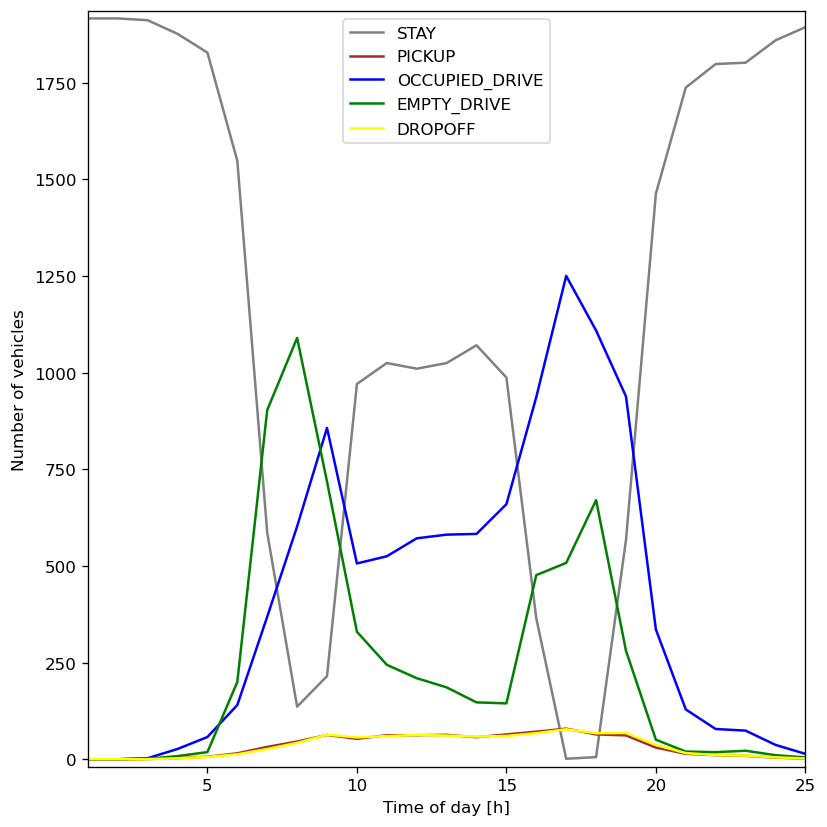

Fig. 5: Duration of task 


In [54]:
plt.figure(figsize = (7, 7), dpi = 120)

'''
for col in df_task_time_profiles_taxi.columns:
    if (str(col) == "time") or (str(col) == "time_h") or (str(col) == "time_in_s") :
        print("")
    
    else :
        plt.plot(df_task_time_profiles_taxi["time_in_s"], df_task_time_profiles_taxi[col], color = (np.random.random_sample(), np.random.random_sample(), np.random.random_sample()), label = col)#, linestyle = ":")

'''
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["STAY"], color = "gray", label = "STAY")
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["PICKUP"], color = "brown", label = "PICKUP")#, linestyle = ":")
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["OCCUPIED_DRIVE"], color = "blue", label = "OCCUPIED_DRIVE")#, linestyle = ":")
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["EMPTY_DRIVE"], color = "green", label = "EMPTY_DRIVE")#, linestyle = ":")
plt.plot(df_duration_of_tasks_by_type["hour"], df_duration_of_tasks_by_type["DROPOFF"], color = "yellow", label = "DROPOFF")#, linestyle = ":")
plt.xlabel("Time of day [h]")
plt.ylabel("Number of vehicles")


#plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2_v2_15_p_cent/duration_of_tasks_by_type_15_p_cent.pdf', bbox_inches="tight")
plt.close()
print("Fig. 5: Duration of task ")

## Output events analysis

In [55]:
#tree_events = ET.parse(gzip.open("%s/sce2.3agents.output_events.xml.gz" % output_path_3agents,'r'))
#tree_events = ET.parse(gzip.open("%s/sce2.v2.output_events.xml.gz" % output_path,'r'))

tree_events = ET.parse(gzip.open("%s/sce2.v2.output_events.xml.gz" % output_path,'r'))
events  = tree_events.getroot()

In [56]:
events.tag, events.attrib

('events', {'version': '1.0'})

In [57]:
#events[0].tag, events[0].attrib

In [58]:
"""
for event in events.iter('event'):
    print(event.tag, event.attrib)
    #print(event[0])
    print(event.attrib["type"])
    break
"""

'\nfor event in events.iter(\'event\'):\n    print(event.tag, event.attrib)\n    #print(event[0])\n    print(event.attrib["type"])\n    break\n'

In [59]:
def events_stats(events):
    number=len(events)
    print("Number of events :   ",number)
    PassengerRequestSubmitted = len([event for event in events.iter('event') if event.attrib["type"]=="PassengerRequest submitted"])
    print("PassengerRequest submitted :", PassengerRequestSubmitted)
    PassengerRequestScheduled = len([event for event in events.iter('event') if event.attrib["type"]=="PassengerRequest scheduled"])
    print("PassengerRequest scheduled :", PassengerRequestScheduled)
    print("PassengerRequest not performed :", PassengerRequestSubmitted - PassengerRequestScheduled)
    pickupTask = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="PICKUP"])
    print("Number of pickup :", pickupTask)
    dropoffTask = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="DROPOFF"])
    print("Number of dropoff :", dropoffTask)
    occupiedDrive = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="OCCUPIED_DRIVE"])
    print("Number of occupied driving :", occupiedDrive)
    emptyDrive = len([event for event in events.iter('event') if event.attrib["type"]=="dvrpTaskStarted" and event.attrib["taskType"]=="EMPTY_DRIVE"])
    print("Number of empty driving :", emptyDrive)

In [60]:
#events_stats(events)

In [61]:
#rdvrpTaskStarted
time = []
person = []
link = []
dvrpVehicle = []
taskType = []

In [62]:
for event in events.iter('event'):
    if event.attrib["type"]=="dvrpTaskStarted":
        time.append(event.attrib["time"])
        person.append(event.attrib["person"])
        link.append(event.attrib["link"])
        dvrpVehicle.append(event.attrib["dvrpVehicle"])
        taskType.append(event.attrib["taskType"])

In [63]:
df_taskType = pd.DataFrame({"time":time, "person":person, "link": link, "dvrpVehicle" : dvrpVehicle, "taskType" : taskType})

df_taskType.to_csv("%s/df_taskType_taxi.csv" % output_path)

df_taskType_pick = df_taskType[df_taskType["taskType"]=="PICKUP"]

df_nb_pick_vh = df_taskType_pick.groupby(["dvrpVehicle"])["taskType"].count().reset_index(name = "number_of_pickups")

df_nb_pick_vh

,dvrpVehicle,number_of_pickups
0,TAX1001057,36
1,TAX1001423,34
2,TAX1001641,31
3,TAX1001658,45
4,TAX1001734,29
...,...,...
1911,TAXVIL111879,37
1912,TAXVIL11282,36
1913,TAXVIL11470,23
1914,TAXVIL1182,29


## Simulation Output trips cvs analysis

To do :
    - modal share

In [64]:
trips_file = "%s/sce2.v2.output_trips.csv.gz" %output_path
df_trips_output = pd.read_csv(gzip.open(trips_file,'r'), sep=";")

In [65]:
df_trips_output

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_facility_id,start_link,start_x,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop
0,1000008,1,1000008_1,07:03:47,00:24:24,00:05:09,2605,2193,NaN,pt,...,home_474430,8102,844783.995555,6.519932e+06,sec_27677,50655,842728.100000,6.519167e+06,32123.link:pt_32123,32113.link:pt_32113
1,1000008,2,1000008_2,07:28:11,00:29:55,00:01:52,8913,7331,NaN,pt,...,sec_27677,50655,842728.100000,6.519167e+06,work_263614,51370,841768.160000,6.511899e+06,166.link:11588,30528.link:51396
2,1000008,3,1000008_3,12:03:47,00:10:16,00:00:00,740,569,NaN,walk,...,work_263614,51370,841768.160000,6.511899e+06,sec_45586,32552,841455.790000,6.511423e+06,NaN,NaN
3,1000008,4,1000008_4,12:33:47,00:10:16,00:00:00,740,569,NaN,walk,...,sec_45586,32552,841455.790000,6.511423e+06,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN
4,1000008,5,1000008_5,17:33:47,00:48:58,00:14:10,11849,8580,NaN,pt,...,work_263614,51370,841768.160000,6.511899e+06,home_474430,8102,844783.995555,6.519932e+06,30529.link:51389,32122.link:pt_32122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230996,999994,2,999994_2,07:02:22,00:06:15,00:00:00,1470,802,NaN,car,...,sec_42480,69858,847968.600000,6.518541e+06,edu_1135,33122,847319.700000,6.519014e+06,NaN,NaN
230997,999994,3,999994_3,16:40:19,00:28:51,00:00:00,11045,7480,NaN,car,...,edu_1135,33122,847319.700000,6.519014e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN
230998,999995,1,999995_1,06:59:18,00:09:25,00:00:00,3605,2768,NaN,car,...,home_474420,17018,854492.550000,6.521136e+06,edu_1164,44221,857259.400000,6.521244e+06,NaN,NaN
230999,999995,2,999995_2,10:42:27,00:07:56,00:00:00,3719,2768,NaN,car,...,edu_1164,44221,857259.400000,6.521244e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN


In [66]:
df_trips_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231001 entries, 0 to 231000
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   person                  231001 non-null  int64  
 1   trip_number             231001 non-null  int64  
 2   trip_id                 231001 non-null  object 
 3   dep_time                231001 non-null  object 
 4   trav_time               231001 non-null  object 
 5   wait_time               231001 non-null  object 
 6   traveled_distance       231001 non-null  int64  
 7   euclidean_distance      231001 non-null  int64  
 8   main_mode               0 non-null       float64
 9   longest_distance_mode   231001 non-null  object 
 10  modes                   231001 non-null  object 
 11  start_activity_type     231001 non-null  object 
 12  end_activity_type       231001 non-null  object 
 13  start_facility_id       231001 non-null  object 
 14  start_link          

In [67]:
df_trips_output.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
person,231001.0,6.289656e+05,363804.109449,4.400000e+01,314973.00,627112.00,944028.00,1262501.0
trip_number,231001.0,2.841555e+00,1.918186,1.000000e+00,1.00,2.00,4.00,19.0
traveled_distance,231001.0,3.995579e+03,4631.070753,0.000000e+00,800.00,2173.00,5587.00,49932.0
euclidean_distance,231001.0,2.485853e+03,2972.755428,0.000000e+00,562.00,1216.00,3449.00,29288.0
main_mode,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_link,231001.0,4.444137e+04,25415.533667,3.000000e+00,23305.00,43847.00,66286.00,88997.0
start_x,231001.0,8.446533e+05,4397.854562,8.317482e+05,841833.32,844518.39,847038.05,859982.0
start_y,231001.0,6.518292e+06,4606.312773,6.497050e+06,6516376.40,6519019.09,6520945.75,6539158.2
end_link,231001.0,4.444969e+04,25414.086651,3.000000e+00,23336.00,43852.00,66287.00,88997.0
end_x,231001.0,8.446534e+05,4396.979030,8.317482e+05,841833.32,844518.39,847038.50,859982.0


In [68]:
df_trips_output["dep_time_in_s"] = df_trips_output["dep_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output["trav_time_in_s"] = df_trips_output["trav_time"].apply(convert_time_h_m_s).astype(float)
df_trips_output["wait_time_in_s"] = df_trips_output["wait_time"].apply(convert_time_h_m_s).astype(float)

In [69]:
df_trips_output

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s
0,1000008,1,1000008_1,07:03:47,00:24:24,00:05:09,2605,2193,NaN,pt,...,6.519932e+06,sec_27677,50655,842728.100000,6.519167e+06,32123.link:pt_32123,32113.link:pt_32113,25427.0,1464.0,309.0
1,1000008,2,1000008_2,07:28:11,00:29:55,00:01:52,8913,7331,NaN,pt,...,6.519167e+06,work_263614,51370,841768.160000,6.511899e+06,166.link:11588,30528.link:51396,26891.0,1795.0,112.0
2,1000008,3,1000008_3,12:03:47,00:10:16,00:00:00,740,569,NaN,walk,...,6.511899e+06,sec_45586,32552,841455.790000,6.511423e+06,NaN,NaN,43427.0,616.0,0.0
3,1000008,4,1000008_4,12:33:47,00:10:16,00:00:00,740,569,NaN,walk,...,6.511423e+06,work_263614,51370,841768.160000,6.511899e+06,NaN,NaN,45227.0,616.0,0.0
4,1000008,5,1000008_5,17:33:47,00:48:58,00:14:10,11849,8580,NaN,pt,...,6.511899e+06,home_474430,8102,844783.995555,6.519932e+06,30529.link:51389,32122.link:pt_32122,63227.0,2938.0,850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230996,999994,2,999994_2,07:02:22,00:06:15,00:00:00,1470,802,NaN,car,...,6.518541e+06,edu_1135,33122,847319.700000,6.519014e+06,NaN,NaN,25342.0,375.0,0.0
230997,999994,3,999994_3,16:40:19,00:28:51,00:00:00,11045,7480,NaN,car,...,6.519014e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN,60019.0,1731.0,0.0
230998,999995,1,999995_1,06:59:18,00:09:25,00:00:00,3605,2768,NaN,car,...,6.521136e+06,edu_1164,44221,857259.400000,6.521244e+06,NaN,NaN,25158.0,565.0,0.0
230999,999995,2,999995_2,10:42:27,00:07:56,00:00:00,3719,2768,NaN,car,...,6.521244e+06,home_474420,17018,854492.550000,6.521136e+06,NaN,NaN,38547.0,476.0,0.0


In [70]:
time_class = np.arange(0, 30) * 3600

In [71]:
time_class

array([     0,   3600,   7200,  10800,  14400,  18000,  21600,  25200,
        28800,  32400,  36000,  39600,  43200,  46800,  50400,  54000,
        57600,  61200,  64800,  68400,  72000,  75600,  79200,  82800,
        86400,  90000,  93600,  97200, 100800, 104400])

In [72]:
df_trips_output["dep_time_class"] = np.digitize(df_trips_output["dep_time_in_s"], time_class)

Text(0.5, 0, 'Time [h]')

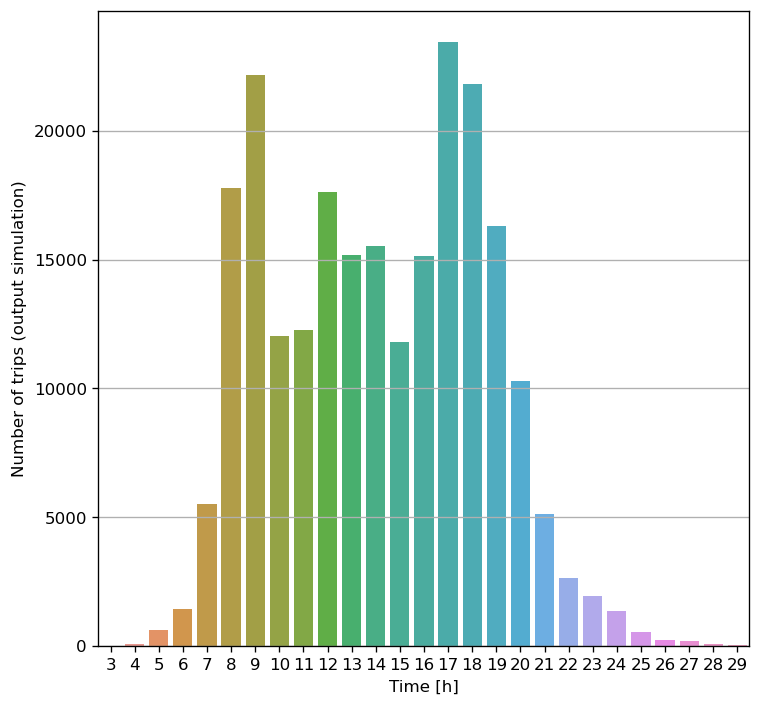

In [73]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output)
ax.grid(axis='y')
plt.ylabel("Number of trips (output simulation)")
plt.xlabel("Time [h]")

In [74]:
df_trips_output_taxi = df_trips_output[df_trips_output["longest_distance_mode"]=="taxi"]
df_trips_output_taxi

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class
9,1000009,3,1000009_3,20:24:38,00:06:46,00:00:22,1304,556,NaN,taxi,...,sec_17516,18634,844413.600000,6.520347e+06,NaN,NaN,73478.0,406.0,22.0,21
10,1000009,4,1000009_4,20:31:24,00:05:17,00:00:34,1190,556,NaN,taxi,...,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN,73884.0,317.0,34.0,21
11,1000010,1,1000010_1,07:41:45,01:03:19,00:43:05,3195,2522,NaN,taxi,...,sec_22644,15949,847012.540000,6.518749e+06,NaN,NaN,27705.0,3799.0,2585.0,8
12,1000010,2,1000010_2,08:45:04,00:20:58,00:00:02,3510,2522,NaN,taxi,...,home_474430,8102,844783.995555,6.519932e+06,NaN,NaN,31504.0,1258.0,2.0,9
13,1000010,3,1000010_3,09:06:02,00:10:33,00:02:50,559,322,NaN,taxi,...,sec_26273,39664,844906.620000,6.520230e+06,NaN,NaN,32762.0,633.0,170.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230956,999624,2,999624_2,19:36:56,00:16:23,00:04:10,2588,1528,NaN,taxi,...,home_474216,22371,849876.617760,6.522228e+06,NaN,NaN,70616.0,983.0,250.0,20
230976,999871,1,999871_1,08:55:42,00:33:38,00:15:59,4189,2658,NaN,taxi,...,work_153947,27146,844019.770000,6.517061e+06,NaN,NaN,32142.0,2018.0,959.0,9
230977,999871,2,999871_2,17:23:31,00:27:35,00:02:50,4689,2658,NaN,taxi,...,home_474345,73761,846557.250000,6.516266e+06,NaN,NaN,62611.0,1655.0,170.0,18
230987,999946,3,999946_3,14:43:07,00:13:16,00:01:48,2507,1860,NaN,taxi,...,sec_9767,23235,839282.900000,6.518634e+06,NaN,NaN,52987.0,796.0,108.0,15


Text(0.5, 0, 'Time [h]')

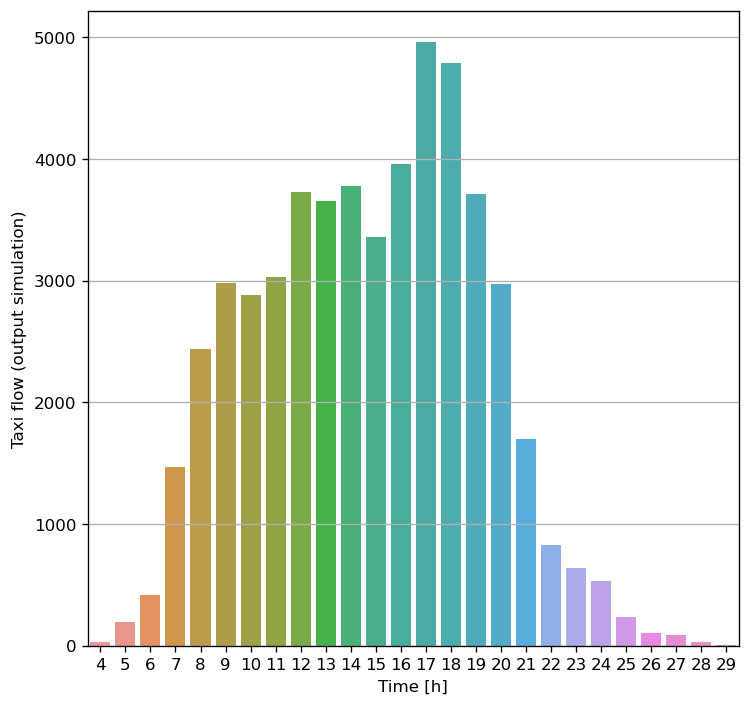

In [75]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output_taxi)
ax.grid(axis='y')
plt.ylabel("Taxi flow (output simulation)")
plt.xlabel("Time [h]")

In [76]:
wait_time_class = [0, 300, 600, 900, 1800, 3600, np.inf]

In [77]:
df_trips_output_taxi["wait_time_class"] = np.digitize(df_trips_output_taxi["wait_time_in_s"], wait_time_class)

/tmp/ipykernel_207433/2296968742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trips_output_taxi["wait_time_class"] = np.digitize(df_trips_output_taxi["wait_time_in_s"], wait_time_class)


Text(0.5, 0, 'Waiting time [min]')

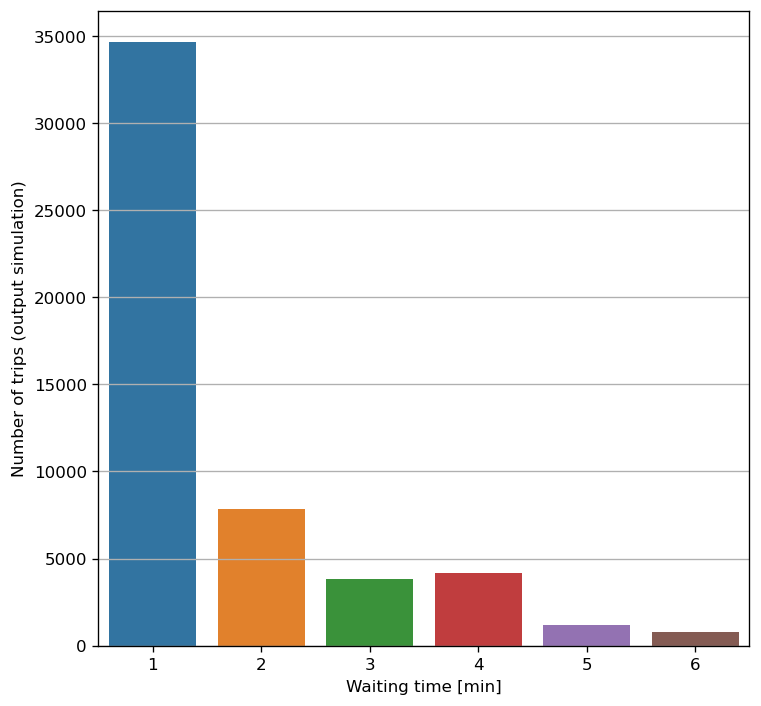

In [78]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="wait_time_class", data=df_trips_output_taxi)
ax.grid(axis='y')
plt.ylabel("Number of trips (output simulation)")
plt.xlabel("Waiting time [min]")

In [79]:
#waiting mean time by time of day
df_wait_mean = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").mean().reset_index().rename({ "wait_time_in_s" : "avg" }, axis = 1)
#waiting median time by time of day
df_wait_median = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").median().reset_index().rename({ "wait_time_in_s" : "50%ile" }, axis = 1)
#waiting min time by time of day
df_wait_min = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").min().reset_index().rename({ "wait_time_in_s" : "min" }, axis = 1)
#waiting max time by time of day
df_wait_max = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").max().reset_index().rename({ "wait_time_in_s" : "max" }, axis = 1)
#waiting std time by time of day
df_wait_std = df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").std().reset_index().rename({ "wait_time_in_s" : "std" }, axis = 1)

In [80]:
#waiting 5% time by time of day
#percentile_5 = np.percentile(df_trips_output_taxi[["dep_time_class", "wait_time_in_s"]].groupby("dep_time_class").value_counts, 5)

In [81]:
df_wait_time = pd.merge(df_wait_mean, df_wait_median, on = "dep_time_class")

In [82]:
df_wait_time

,dep_time_class,avg,50%ile
0,4,160.766667,163.0
1,5,162.840206,151.0
2,6,167.524155,146.0
3,7,1095.533696,604.0
4,8,2083.173164,1100.0
5,9,1802.289068,776.5
6,10,340.571825,230.0
7,11,94.243734,67.0
8,12,95.957652,71.0
9,13,106.254993,76.0


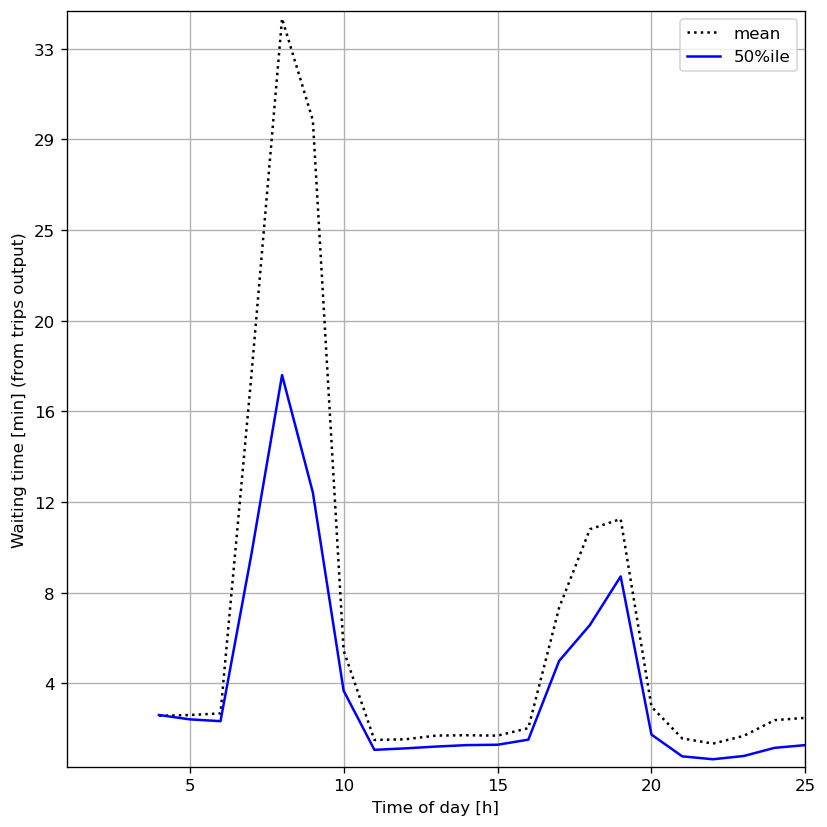

Fig. 6: Passenger wait times for each hour (from trips output)


In [83]:
plt.figure(figsize = (7, 7), dpi = 120)

plt.plot(df_wait_time["dep_time_class"], df_wait_time["avg"], color = "black", label = "mean", linestyle = ":")
plt.plot(df_wait_time["dep_time_class"], df_wait_time["50%ile"], color = "blue", label = "50%ile")#, linestyle = ":")

plt.xlabel("Time of day [h]")
plt.ylabel("Waiting time [min] (from trips output)")

plt.gca().yaxis.set_major_formatter(tck.FuncFormatter(
        lambda x, k: "%d" % (x/60)
))

plt.grid()
plt.gca().set_axisbelow(True)
plt.xlim([1, 25])
plt.legend(loc = "best")
plt.margins(x=0.01)
plt.margins(y=0.01)
plt.tight_layout()
plt.show()
#plt.savefig('/media/aodiallo/Data/MATSIM/Simulation/robotaxi/output/Graphes/sc2/trips_ouput_passenger_wait_time_c2.pdf')
plt.close()
print("Fig. 6: Passenger wait times for each hour (from trips output)")

#### Plus de 30 min d'attente

In [84]:
df_trips_output_taxi_wait_30 = df_trips_output_taxi[df_trips_output_taxi["wait_time_in_s"]>= 1800]

In [85]:
df_trips_output_taxi_wait_30

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class,wait_time_class
11,1000010,1,1000010_1,07:41:45,01:03:19,00:43:05,3195,2522,NaN,taxi,...,15949,847012.54,6518748.82,NaN,NaN,27705.0,3799.0,2585.0,8,5
215,100043,1,100043_1,06:45:19,00:52:21,00:44:53,2054,1309,NaN,taxi,...,72241,849916.20,6521824.00,NaN,NaN,24319.0,3141.0,2693.0,7,5
245,1000607,2,1000607_2,17:03:15,00:51:29,00:37:17,7427,4134,NaN,taxi,...,84767,847373.00,6516820.20,NaN,NaN,61395.0,3089.0,2237.0,18,5
328,1001153,1,1001153_1,07:13:00,01:24:53,01:03:28,7908,5073,NaN,taxi,...,10329,838652.86,6519839.38,NaN,NaN,25980.0,5093.0,3808.0,8,6
337,1001154,6,1001154_6,18:58:20,00:56:20,00:42:33,1732,1116,NaN,taxi,...,84701,843723.09,6520008.56,NaN,NaN,68300.0,3380.0,2553.0,19,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230419,996259,2,996259_2,17:41:09,01:40:45,01:20:40,12634,7577,NaN,taxi,...,23198,847974.00,6516596.00,NaN,NaN,63669.0,6045.0,4840.0,18,6
230422,996260,3,996260_3,08:42:29,04:51:18,04:30:54,12395,6878,NaN,taxi,...,71112,844529.57,6511623.07,NaN,NaN,31349.0,17478.0,16254.0,9,6
230492,996609,1,996609_1,07:31:39,00:52:03,00:38:44,3228,2276,NaN,taxi,...,38722,844862.00,6519426.00,NaN,NaN,27099.0,3123.0,2324.0,8,5
230502,996669,1,996669_1,07:05:55,01:03:50,00:50:54,3229,1518,NaN,taxi,...,6217,844571.17,6518684.83,NaN,NaN,25555.0,3830.0,3054.0,8,5


#### Plus de 60 min d'attente

In [86]:
df_trips_output_taxi[df_trips_output_taxi["wait_time_in_s"]>= 3600]

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class,wait_time_class
328,1001153,1,1001153_1,07:13:00,01:24:53,01:03:28,7908,5073,NaN,taxi,...,10329,838652.86,6519839.38,NaN,NaN,25980.0,5093.0,3808.0,8,6
623,1003124,1,1003124_1,07:39:42,01:55:42,01:43:40,2016,1155,NaN,taxi,...,11196,845222.70,6517333.50,NaN,NaN,27582.0,6942.0,6220.0,8,6
704,1003459,1,1003459_1,07:34:37,02:06:21,01:51:48,6605,4290,NaN,taxi,...,54539,845631.90,6525670.20,NaN,NaN,27277.0,7581.0,6708.0,8,6
833,100428,1,100428_1,07:38:26,01:45:30,01:29:14,5200,2410,NaN,taxi,...,30529,847256.77,6517598.90,NaN,NaN,27506.0,6330.0,5354.0,8,6
934,1005159,1,1005159_1,07:21:05,03:26:28,03:17:28,2247,1658,NaN,taxi,...,54261,847055.70,6520369.73,NaN,NaN,26465.0,12388.0,11848.0,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230165,995063,4,995063_4,17:09:59,02:22:01,01:48:10,16922,11431,NaN,taxi,...,4162,849172.89,6523132.70,NaN,NaN,61799.0,8521.0,6490.0,18,6
230312,995826,1,995826_1,07:44:14,02:08:29,01:57:53,2641,1246,NaN,taxi,...,6836,843978.90,6516343.30,NaN,NaN,27854.0,7709.0,7073.0,8,6
230353,995882,1,995882_1,08:07:07,02:20:01,02:13:43,1361,869,NaN,taxi,...,15973,843537.20,6520027.60,NaN,NaN,29227.0,8401.0,8023.0,9,6
230419,996259,2,996259_2,17:41:09,01:40:45,01:20:40,12634,7577,NaN,taxi,...,23198,847974.00,6516596.00,NaN,NaN,63669.0,6045.0,4840.0,18,6


#### Plus de 2h d'attente

In [87]:
df_trips_output_taxi[df_trips_output_taxi["wait_time_in_s"]>= 7200]

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class,wait_time_class
934,1005159,1,1005159_1,07:21:05,03:26:28,03:17:28,2247,1658,NaN,taxi,...,54261,847055.700000,6.520370e+06,NaN,NaN,26465.0,12388.0,11848.0,8,6
1340,1006465,1,1006465_1,07:25:02,03:51:07,03:33:22,2157,1467,NaN,taxi,...,6918,847602.300000,6.520985e+06,NaN,NaN,26702.0,13867.0,12802.0,8,6
1524,100717,1,100717_1,08:42:54,05:23:33,05:10:24,5514,3203,NaN,taxi,...,68633,849363.110000,6.512892e+06,NaN,NaN,31374.0,19413.0,18624.0,9,6
2355,1010579,1,1010579_1,08:45:36,05:50:37,05:38:14,4938,4472,NaN,taxi,...,25535,850260.300000,6.518109e+06,NaN,NaN,31536.0,21037.0,20294.0,9,6
2966,1014050,1,1014050_1,07:46:19,02:21:05,02:03:25,1694,927,NaN,taxi,...,82054,844070.680000,6.518185e+06,NaN,NaN,27979.0,8465.0,7405.0,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227763,983084,3,983084_3,08:42:30,04:46:15,04:40:16,1462,672,NaN,taxi,...,51370,841768.160000,6.511899e+06,NaN,NaN,31350.0,17175.0,16816.0,9,6
227995,984358,1,984358_1,07:24:58,03:39:37,03:23:09,11991,6867,NaN,taxi,...,61178,853294.046589,6.516167e+06,NaN,NaN,26698.0,13177.0,12189.0,8,6
229572,992683,1,992683_1,07:01:40,02:48:49,02:42:10,1392,924,NaN,taxi,...,70554,845213.500000,6.518076e+06,NaN,NaN,25300.0,10129.0,9730.0,8,6
230353,995882,1,995882_1,08:07:07,02:20:01,02:13:43,1361,869,NaN,taxi,...,15973,843537.200000,6.520028e+06,NaN,NaN,29227.0,8401.0,8023.0,9,6


#### Plus de 3h d'attente

In [88]:
df_trips_output_taxi[df_trips_output_taxi["wait_time_in_s"]>= 10800]

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,dep_time_in_s,trav_time_in_s,wait_time_in_s,dep_time_class,wait_time_class
934,1005159,1,1005159_1,07:21:05,03:26:28,03:17:28,2247,1658,NaN,taxi,...,54261,847055.700000,6.520370e+06,NaN,NaN,26465.0,12388.0,11848.0,8,6
1340,1006465,1,1006465_1,07:25:02,03:51:07,03:33:22,2157,1467,NaN,taxi,...,6918,847602.300000,6.520985e+06,NaN,NaN,26702.0,13867.0,12802.0,8,6
1524,100717,1,100717_1,08:42:54,05:23:33,05:10:24,5514,3203,NaN,taxi,...,68633,849363.110000,6.512892e+06,NaN,NaN,31374.0,19413.0,18624.0,9,6
2355,1010579,1,1010579_1,08:45:36,05:50:37,05:38:14,4938,4472,NaN,taxi,...,25535,850260.300000,6.518109e+06,NaN,NaN,31536.0,21037.0,20294.0,9,6
3384,1016364,1,1016364_1,08:45:56,05:57:30,05:45:58,4046,2877,NaN,taxi,...,31909,845622.280000,6.516494e+06,NaN,NaN,31556.0,21450.0,20758.0,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225216,970062,1,970062_1,08:44:22,05:42:47,05:28:47,2022,879,NaN,taxi,...,17609,839665.700000,6.520429e+06,NaN,NaN,31462.0,20567.0,19727.0,9,6
227275,981024,1,981024_1,08:46:11,05:38:51,05:23:10,4567,3175,NaN,taxi,...,74858,846075.800000,6.525820e+06,NaN,NaN,31571.0,20331.0,19390.0,9,6
227763,983084,3,983084_3,08:42:30,04:46:15,04:40:16,1462,672,NaN,taxi,...,51370,841768.160000,6.511899e+06,NaN,NaN,31350.0,17175.0,16816.0,9,6
227995,984358,1,984358_1,07:24:58,03:39:37,03:23:09,11991,6867,NaN,taxi,...,61178,853294.046589,6.516167e+06,NaN,NaN,26698.0,13177.0,12189.0,8,6


To do :

    - 90 percentile de temps d'attente
    
    - Projection des déplacements en fonction des O/D

## Investigation des agents qui ont un temps d'attente trop important à partir des plans d'entrée/sortie (cas de la personne 1005159 par exemple)

### Input MATSim synthetic population (plans)

In [89]:
input_trips_file = "%s/df_trips_input_plans_sce2.csv" %output_path
input_persons_file = "%s/df_persons_input_perons_sce2.csv" %output_path
df_persons_input = pd.read_csv(input_persons_file)
df_trips_input = pd.read_csv(input_trips_file)

In [90]:
df_persons_input

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id
0,0,32,none,none,183012,377986,True,yes,False,474430,4476.391583,8484,18514,False,m,urban_motorized,1000008
1,1,32,all,none,183012,377986,True,yes,False,474430,4476.391583,1537,3356,False,m,urban_motorized,1000009
2,2,32,some,none,183012,377986,True,yes,False,474430,4476.391583,4923,10846,True,m,urban_motorized,1000010
3,3,33,none,none,18480,38075,False,yes,True,47644,2083.709401,8999,19603,False,m,peripheral_motorized,100002
4,4,33,all,none,18480,38075,False,yes,False,47644,2083.709401,1830,3991,False,m,peripheral_motorized,100003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63165,63165,66,none,none,182997,377959,True,yes,False,474396,3022.192917,680,1540,False,f,urban_motorized,999947
63166,63166,25,none,none,183008,377980,False,yes,False,474420,4924.560292,535,1230,False,m,peripheral_motorized,999992
63167,63167,25,none,none,183008,377980,False,no,True,474420,4924.560292,7535,16468,False,m,peripheral_motorized,999993
63168,63168,23,none,none,183008,377981,False,yes,False,474420,4924.560292,3375,7270,False,f,peripheral_motorized,999994


In [91]:
df_trips_input

,Unnamed: 0,person_id,departure_time,arrival_time,mode,preceding_purpose,from_x,from_y,preceding_purpose_start_time,preceding_purpose_end_time,following_purpose,to_x,to_y,following_purpose_start_time,following_purpose_end_time,is_first,is_last
0,0,1000008,07:03:47,07:13:47,taxi,home,844783.995555,6.519932e+06,NaN,07:03:47,other,842728.100000,6.519167e+06,07:13:47,07:13:47,True,False
1,1,1000008,07:13:47,07:58:47,taxi,other,842728.100000,6.519167e+06,07:13:47,07:13:47,work,841768.160000,6.511899e+06,07:58:47,12:03:47,False,False
2,2,1000008,12:03:47,12:13:47,walk,work,841768.160000,6.511899e+06,07:58:47,12:03:47,leisure,841455.790000,6.511423e+06,12:13:47,12:33:47,False,False
3,3,1000008,12:33:47,12:43:47,walk,leisure,841455.790000,6.511423e+06,12:13:47,12:33:47,work,841768.160000,6.511899e+06,12:43:47,17:33:47,False,False
4,4,1000008,17:33:47,18:18:47,taxi,work,841768.160000,6.511899e+06,12:43:47,17:33:47,home,844783.995555,6.519932e+06,18:18:47,19:28:47,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354570,354570,999994,07:05:31,07:15:31,car,other,847968.600000,6.518541e+06,07:05:31,07:05:31,education,847319.700000,6.519014e+06,07:15:31,16:15:31,False,False
354571,354571,999994,16:15:31,16:45:31,car,education,847319.700000,6.519014e+06,07:15:31,16:15:31,home,854492.550000,6.521136e+06,16:45:31,NaN,False,True
354572,354572,999995,07:13:37,07:48:37,car,home,854492.550000,6.521136e+06,NaN,07:13:37,education,857259.400000,6.521244e+06,07:48:37,11:28:37,True,False
354573,354573,999995,11:28:37,12:13:37,car,education,857259.400000,6.521244e+06,07:48:37,11:28:37,home,854492.550000,6.521136e+06,12:13:37,18:28:37,False,False


In [92]:
df_count_trips = df_trips_input[["person_id"]].groupby("person_id").size().reset_index(name = "number_of_trips")

In [93]:
df_persons_input = pd.merge(df_persons_input, df_count_trips, on = "person_id", how = "left")

In [94]:
df_persons_input

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id,number_of_trips
0,0,32,none,none,183012,377986,True,yes,False,474430,4476.391583,8484,18514,False,m,urban_motorized,1000008,7
1,1,32,all,none,183012,377986,True,yes,False,474430,4476.391583,1537,3356,False,m,urban_motorized,1000009,4
2,2,32,some,none,183012,377986,True,yes,False,474430,4476.391583,4923,10846,True,m,urban_motorized,1000010,11
3,3,33,none,none,18480,38075,False,yes,True,47644,2083.709401,8999,19603,False,m,peripheral_motorized,100002,11
4,4,33,all,none,18480,38075,False,yes,False,47644,2083.709401,1830,3991,False,m,peripheral_motorized,100003,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63165,63165,66,none,none,182997,377959,True,yes,False,474396,3022.192917,680,1540,False,f,urban_motorized,999947,6
63166,63166,25,none,none,183008,377980,False,yes,False,474420,4924.560292,535,1230,False,m,peripheral_motorized,999992,2
63167,63167,25,none,none,183008,377980,False,no,True,474420,4924.560292,7535,16468,False,m,peripheral_motorized,999993,6
63168,63168,23,none,none,183008,377981,False,yes,False,474420,4924.560292,3375,7270,False,f,peripheral_motorized,999994,3


In [95]:
df_persons_input.describe()

,Unnamed: 0,age,censusHouseholdId,censusPersonId,householdId,householdIncome,htsHouseholdId,htsPersonId,person_id,number_of_trips
count,63170.000000,63170.000000,63170.000000,63170.000000,63170.000000,63170.000000,63170.000000,63170.000000,6.317000e+04,63170.000000
mean,31584.500000,38.979785,115190.553491,237754.159189,298632.387700,3599.659921,4830.610258,10555.298085,6.289073e+05,5.613028
std,18235.752589,23.621753,66678.563614,137615.109477,173196.011417,2393.098721,2825.403738,6165.745949,3.647161e+05,4.064752
min,0.000000,0.000000,12.000000,21.000000,23.000000,0.127335,0.000000,0.000000,4.400000e+01,1.000000
25%,15792.250000,20.000000,57707.000000,119054.250000,149380.000000,1983.152557,2289.000000,4974.000000,3.140832e+05,2.000000
50%,31584.500000,36.000000,114643.000000,236714.500000,297068.000000,3104.406876,4873.000000,10698.500000,6.261755e+05,4.000000
75%,47376.750000,57.000000,172964.500000,357205.500000,448436.250000,4682.748186,7388.000000,16110.000000,9.448258e+05,7.000000
max,63169.000000,113.000000,232639.000000,472659.000000,614745.000000,37862.255773,9745.000000,21060.000000,1.262501e+06,43.000000


In [96]:
df_trips_input["dep_time_in_s"] = df_trips_input["departure_time"].apply(convert_time_h_m_s).astype(float)

In [97]:
df_trips_input["dep_time_class"] = np.digitize(df_trips_input["dep_time_in_s"], time_class)

In [98]:
f_taxi = df_trips_input["mode"] == "taxi"

In [99]:
df_trips_input_taxi = df_trips_input[f_taxi]

In [100]:
df_trips_input_taxi

,Unnamed: 0,person_id,departure_time,arrival_time,mode,preceding_purpose,from_x,from_y,preceding_purpose_start_time,preceding_purpose_end_time,following_purpose,to_x,to_y,following_purpose_start_time,following_purpose_end_time,is_first,is_last,dep_time_in_s,dep_time_class
0,0,1000008,07:03:47,07:13:47,taxi,home,844783.995555,6.519932e+06,NaN,07:03:47,other,842728.100000,6.519167e+06,07:13:47,07:13:47,True,False,25427.0,8
1,1,1000008,07:13:47,07:58:47,taxi,other,842728.100000,6.519167e+06,07:13:47,07:13:47,work,841768.160000,6.511899e+06,07:58:47,12:03:47,False,False,26027.0,8
4,4,1000008,17:33:47,18:18:47,taxi,work,841768.160000,6.511899e+06,12:43:47,17:33:47,home,844783.995555,6.519932e+06,18:18:47,19:28:47,False,False,63227.0,18
5,5,1000008,19:28:47,19:38:47,taxi,home,844783.995555,6.519932e+06,18:18:47,19:28:47,other,842067.600000,6.518710e+06,19:38:47,19:43:47,False,False,70127.0,20
6,6,1000008,19:43:47,19:53:47,taxi,other,842067.600000,6.518710e+06,19:38:47,19:43:47,home,844783.995555,6.519932e+06,19:53:47,NaN,False,True,71027.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354511,354511,999674,07:57:11,08:32:11,taxi,home,845450.080000,6.518884e+06,NaN,07:57:11,work,841840.120000,6.515749e+06,08:32:11,16:42:11,True,False,28631.0,8
354512,354512,999674,16:42:11,17:22:11,taxi,work,841840.120000,6.515749e+06,08:32:11,16:42:11,leisure,846659.700000,6.520819e+06,17:22:11,20:27:11,False,False,60131.0,17
354513,354513,999674,20:27:11,20:37:11,taxi,leisure,846659.700000,6.520819e+06,17:22:11,20:27:11,home,845450.080000,6.518884e+06,20:37:11,NaN,False,True,73631.0,21
354538,354538,999871,08:43:59,09:13:59,taxi,home,846557.250000,6.516266e+06,NaN,08:43:59,work,844019.770000,6.517061e+06,09:13:59,17:13:59,True,False,31439.0,9


Text(0.5, 0, 'Time of day [h]')

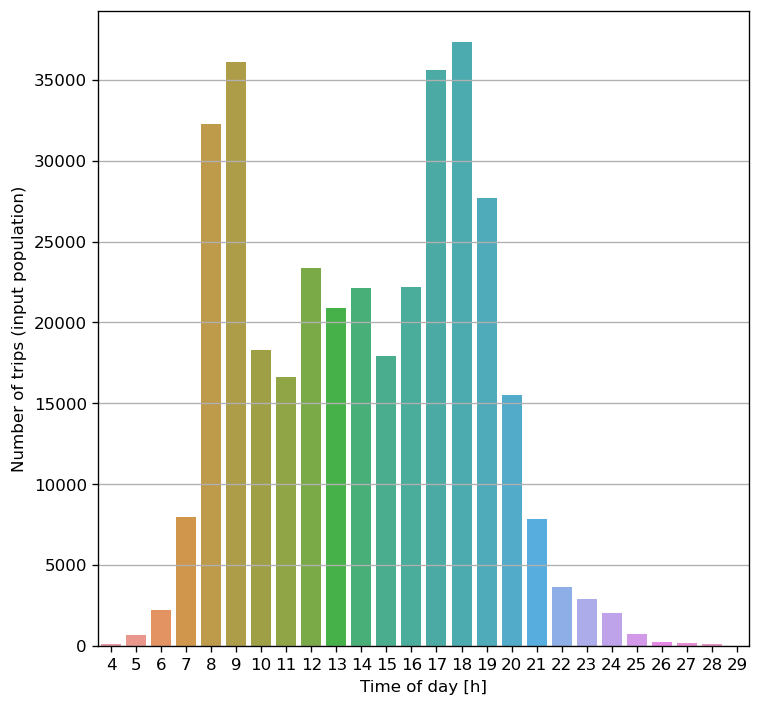

In [101]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_input)
ax.grid(axis='y')
plt.ylabel("Number of trips (input population)")
plt.xlabel("Time of day [h]")

Text(0.5, 0, 'Time of day [h]')

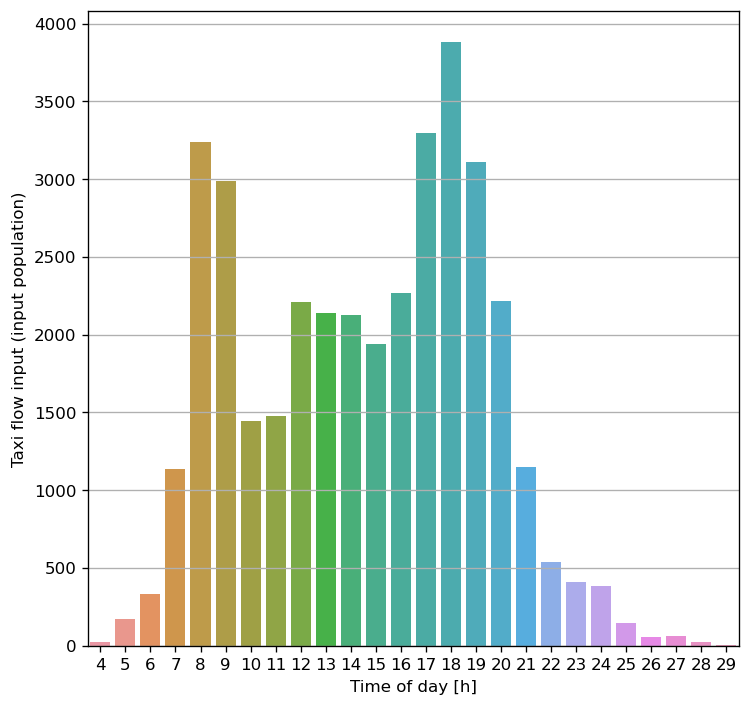

In [102]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_input_taxi)
ax.grid(axis='y')
plt.ylabel("Taxi flow input (input population)")
plt.xlabel("Time of day [h]")

### MATSim simulation output plans

In [103]:
output_trips_file = "%s/df_trips_simulation_output_plans_sce2.csv" %output_path
output_persons_file = "%s/df_persons_output_perons_sce2.csv" %output_path
df_persons_output_pln = pd.read_csv(output_persons_file)
df_trips_output_pln = pd.read_csv(output_trips_file)

In [104]:
df_persons_output_pln

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id
0,0,32,none,none,183012,377986,True,yes,False,474430,4476.391583,8484,18514,False,m,urban_motorized,1000008
1,1,32,all,none,183012,377986,True,yes,False,474430,4476.391583,1537,3356,False,m,urban_motorized,1000009
2,2,32,some,none,183012,377986,True,yes,False,474430,4476.391583,4923,10846,True,m,urban_motorized,1000010
3,3,33,none,none,18480,38075,False,yes,True,47644,2083.709401,8999,19603,False,m,peripheral_motorized,100002
4,4,33,all,none,18480,38075,False,yes,False,47644,2083.709401,1830,3991,False,m,peripheral_motorized,100003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63165,63165,66,none,none,182997,377959,True,yes,False,474396,3022.192917,680,1540,False,f,urban_motorized,999947
63166,63166,25,none,none,183008,377980,False,yes,False,474420,4924.560292,535,1230,False,m,peripheral_motorized,999992
63167,63167,25,none,none,183008,377980,False,no,True,474420,4924.560292,7535,16468,False,m,peripheral_motorized,999993
63168,63168,23,none,none,183008,377981,False,yes,False,474420,4924.560292,3375,7270,False,f,peripheral_motorized,999994


In [105]:
df_trips_output_pln

,Unnamed: 0,person_id,departure_time,arrival_time,mode,preceding_purpose,from_x,from_y,preceding_purpose_start_time,preceding_purpose_end_time,following_purpose,to_x,to_y,following_purpose_start_time,following_purpose_end_time,is_first,is_last
0,0,1000008,07:03:47,07:13:47,taxi,home,844783.995555,6.519932e+06,NaN,07:03:47,other,842728.100000,6.519167e+06,07:13:47,07:13:47,True,False
1,1,1000008,07:13:47,07:58:47,taxi,other,842728.100000,6.519167e+06,07:13:47,07:13:47,work,841768.160000,6.511899e+06,07:58:47,12:03:47,False,False
2,2,1000008,12:03:47,12:13:47,walk,work,841768.160000,6.511899e+06,07:58:47,12:03:47,leisure,841455.790000,6.511423e+06,12:13:47,12:33:47,False,False
3,3,1000008,12:33:47,12:43:47,walk,leisure,841455.790000,6.511423e+06,12:13:47,12:33:47,work,841768.160000,6.511899e+06,12:43:47,17:33:47,False,False
4,4,1000008,17:33:47,18:18:47,taxi,work,841768.160000,6.511899e+06,12:43:47,17:33:47,home,844783.995555,6.519932e+06,18:18:47,19:28:47,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354570,354570,999994,07:05:31,07:15:31,car,other,847968.600000,6.518541e+06,07:05:31,07:05:31,education,847319.700000,6.519014e+06,07:15:31,16:15:31,False,False
354571,354571,999994,16:15:31,16:45:31,car,education,847319.700000,6.519014e+06,07:15:31,16:15:31,home,854492.550000,6.521136e+06,16:45:31,NaN,False,True
354572,354572,999995,07:13:37,07:48:37,car,home,854492.550000,6.521136e+06,NaN,07:13:37,education,857259.400000,6.521244e+06,07:48:37,11:28:37,True,False
354573,354573,999995,11:28:37,12:13:37,car,education,857259.400000,6.521244e+06,07:48:37,11:28:37,home,854492.550000,6.521136e+06,12:13:37,18:28:37,False,False


In [106]:
df_count_trips2 = df_trips_output_pln[["person_id"]].groupby("person_id").size().reset_index(name = "number_of_trips")

In [107]:
df_persons_output_pln = pd.merge(df_persons_output_pln, df_count_trips2, on = "person_id", how = "left")

In [108]:
df_persons_output_pln

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id,number_of_trips
0,0,32,none,none,183012,377986,True,yes,False,474430,4476.391583,8484,18514,False,m,urban_motorized,1000008,7
1,1,32,all,none,183012,377986,True,yes,False,474430,4476.391583,1537,3356,False,m,urban_motorized,1000009,4
2,2,32,some,none,183012,377986,True,yes,False,474430,4476.391583,4923,10846,True,m,urban_motorized,1000010,11
3,3,33,none,none,18480,38075,False,yes,True,47644,2083.709401,8999,19603,False,m,peripheral_motorized,100002,11
4,4,33,all,none,18480,38075,False,yes,False,47644,2083.709401,1830,3991,False,m,peripheral_motorized,100003,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63165,63165,66,none,none,182997,377959,True,yes,False,474396,3022.192917,680,1540,False,f,urban_motorized,999947,6
63166,63166,25,none,none,183008,377980,False,yes,False,474420,4924.560292,535,1230,False,m,peripheral_motorized,999992,2
63167,63167,25,none,none,183008,377980,False,no,True,474420,4924.560292,7535,16468,False,m,peripheral_motorized,999993,6
63168,63168,23,none,none,183008,377981,False,yes,False,474420,4924.560292,3375,7270,False,f,peripheral_motorized,999994,3


In [109]:
df_persons_output_pln.describe()

,Unnamed: 0,age,censusHouseholdId,censusPersonId,householdId,householdIncome,htsHouseholdId,htsPersonId,person_id,number_of_trips
count,63170.000000,63170.000000,63170.000000,63170.000000,63170.000000,63170.000000,63170.000000,63170.000000,6.317000e+04,63170.000000
mean,31584.500000,38.979785,115190.553491,237754.159189,298632.387700,3599.659921,4830.610258,10555.298085,6.289073e+05,5.613028
std,18235.752589,23.621753,66678.563614,137615.109477,173196.011417,2393.098721,2825.403738,6165.745949,3.647161e+05,4.064752
min,0.000000,0.000000,12.000000,21.000000,23.000000,0.127335,0.000000,0.000000,4.400000e+01,1.000000
25%,15792.250000,20.000000,57707.000000,119054.250000,149380.000000,1983.152557,2289.000000,4974.000000,3.140832e+05,2.000000
50%,31584.500000,36.000000,114643.000000,236714.500000,297068.000000,3104.406876,4873.000000,10698.500000,6.261755e+05,4.000000
75%,47376.750000,57.000000,172964.500000,357205.500000,448436.250000,4682.748186,7388.000000,16110.000000,9.448258e+05,7.000000
max,63169.000000,113.000000,232639.000000,472659.000000,614745.000000,37862.255773,9745.000000,21060.000000,1.262501e+06,43.000000


In [110]:
df_trips_output_pln["dep_time_in_s"] = df_trips_output_pln["departure_time"].apply(convert_time_h_m_s).astype(float)

In [111]:
df_trips_output_pln["dep_time_class"] = np.digitize(df_trips_output_pln["dep_time_in_s"], time_class)

In [112]:
f_taxi = df_trips_output_pln["mode"] == "taxi"

In [113]:
df_trips_output_taxi_pln = df_trips_output_pln[f_taxi]

In [114]:
df_trips_output_taxi_pln

,Unnamed: 0,person_id,departure_time,arrival_time,mode,preceding_purpose,from_x,from_y,preceding_purpose_start_time,preceding_purpose_end_time,following_purpose,to_x,to_y,following_purpose_start_time,following_purpose_end_time,is_first,is_last,dep_time_in_s,dep_time_class
0,0,1000008,07:03:47,07:13:47,taxi,home,844783.995555,6.519932e+06,NaN,07:03:47,other,842728.100000,6.519167e+06,07:13:47,07:13:47,True,False,25427.0,8
1,1,1000008,07:13:47,07:58:47,taxi,other,842728.100000,6.519167e+06,07:13:47,07:13:47,work,841768.160000,6.511899e+06,07:58:47,12:03:47,False,False,26027.0,8
4,4,1000008,17:33:47,18:18:47,taxi,work,841768.160000,6.511899e+06,12:43:47,17:33:47,home,844783.995555,6.519932e+06,18:18:47,19:28:47,False,False,63227.0,18
5,5,1000008,19:28:47,19:38:47,taxi,home,844783.995555,6.519932e+06,18:18:47,19:28:47,other,842067.600000,6.518710e+06,19:38:47,19:43:47,False,False,70127.0,20
6,6,1000008,19:43:47,19:53:47,taxi,other,842067.600000,6.518710e+06,19:38:47,19:43:47,home,844783.995555,6.519932e+06,19:53:47,NaN,False,True,71027.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354511,354511,999674,07:57:11,08:32:11,taxi,home,845450.080000,6.518884e+06,NaN,07:57:11,work,841840.120000,6.515749e+06,08:32:11,16:42:11,True,False,28631.0,8
354512,354512,999674,16:42:11,17:22:11,taxi,work,841840.120000,6.515749e+06,08:32:11,16:42:11,leisure,846659.700000,6.520819e+06,17:22:11,20:27:11,False,False,60131.0,17
354513,354513,999674,20:27:11,20:37:11,taxi,leisure,846659.700000,6.520819e+06,17:22:11,20:27:11,home,845450.080000,6.518884e+06,20:37:11,NaN,False,True,73631.0,21
354538,354538,999871,08:43:59,09:13:59,taxi,home,846557.250000,6.516266e+06,NaN,08:43:59,work,844019.770000,6.517061e+06,09:13:59,17:13:59,True,False,31439.0,9


Text(0.5, 0, 'Time of day [h]')

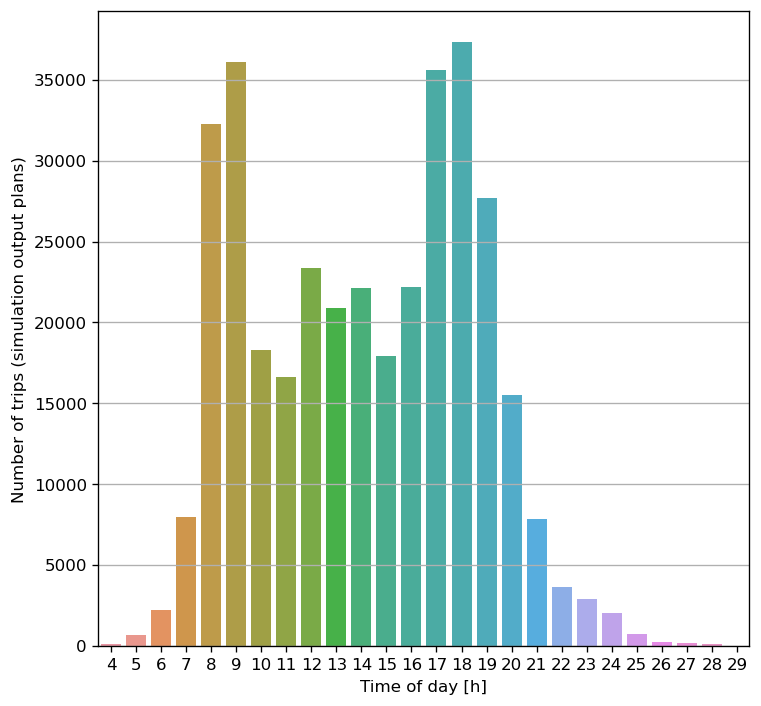

In [115]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output_pln)
ax.grid(axis='y')
plt.ylabel("Number of trips (simulation output plans)")
plt.xlabel("Time of day [h]")

Text(0.5, 0, 'Time of day [h]')

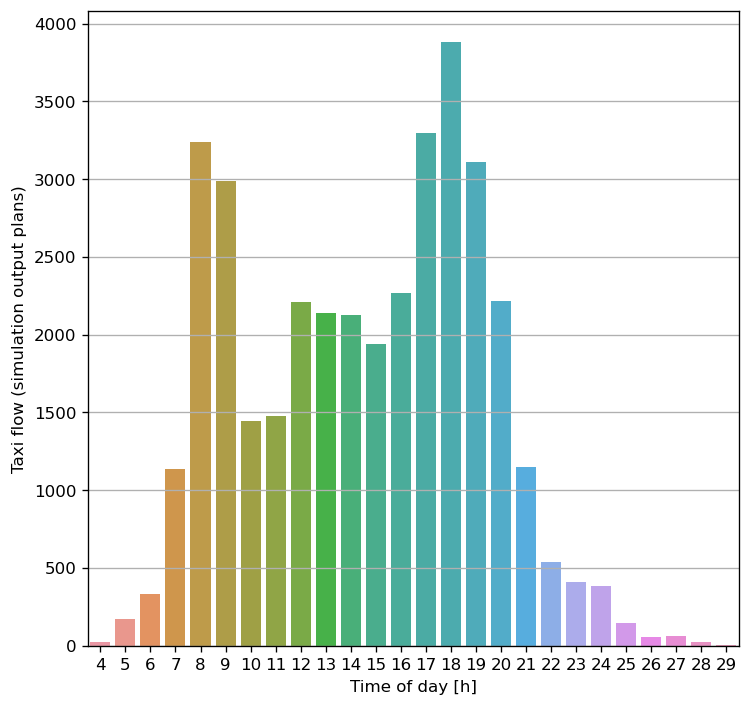

In [116]:
plt.figure(figsize = (7, 7), dpi = 120)
ax = sns.countplot(x="dep_time_class", data=df_trips_output_taxi_pln)
ax.grid(axis='y')
plt.ylabel("Taxi flow (simulation output plans)")
plt.xlabel("Time of day [h]")

**Quelques commentaires**
- 

### Analyse du plan d'activités de la personne 1005159

In [117]:
df_persons_input_100428 = df_persons_input[df_persons_input["person_id"] == 1005159]
df_persons_input_100428

,Unnamed: 0,age,bikeAvailability,carAvailability,censusHouseholdId,censusPersonId,employed,hasLicense,hasPtSubscription,householdId,householdIncome,htsHouseholdId,htsPersonId,isPassenger,sex,subpopulation,person_id,number_of_trips
262,262,55,all,none,183971,379928,False,no,False,476920,2183.769959,2840,6130,False,f,urban_no_motorized,1005159,2


In [118]:
df_trips_input_1005159 = df_trips_input[df_trips_input["person_id"] == 1005159]
df_trips_output_pln_1005159 = df_trips_output_pln[df_trips_output_pln["person_id"] == 1005159]

In [119]:
df_trips_input_1005159.transpose()

,1512,1513
Unnamed: 0,1512,1513
person_id,1005159,1005159
departure_time,07:21:05,15:21:05
arrival_time,07:31:05,15:31:05
mode,walk,walk
preceding_purpose,home,work
from_x,848402.11,847055.7
from_y,6519401.98,6520369.73
preceding_purpose_start_time,NaN,07:31:05
preceding_purpose_end_time,07:21:05,15:21:05


In [120]:
((849638.15 - 847256.77)**2 + (6517972.32 - 6517598.9)**2)**(0.5)

2410.479869403594

In [121]:
df_trips_output_pln_1005159.transpose()

,1512,1513
Unnamed: 0,1512,1513
person_id,1005159,1005159
departure_time,07:21:05,15:21:05
arrival_time,07:31:05,15:31:05
mode,walk,walk
preceding_purpose,home,work
from_x,848402.11,847055.7
from_y,6519401.98,6520369.73
preceding_purpose_start_time,NaN,07:31:05
preceding_purpose_end_time,07:21:05,15:21:05


In [122]:
df_trips_output_taxi[df_trips_output_taxi["person"] == 1005159].transpose()

,934,935
person,1005159,1005159
trip_number,1,2
trip_id,1005159_1,1005159_2
dep_time,07:21:05,15:21:05
trav_time,03:26:28,00:15:13
wait_time,03:17:28,00:04:43
traveled_distance,2247,2464
euclidean_distance,1658,1658
main_mode,NaN,NaN
longest_distance_mode,taxi,taxi


In [123]:
df_taxi_trips_1005159 = df_trips_output_taxi[df_trips_output_taxi["person"] == 1005159]

In [124]:
## Ville O/D des déplacements de l'agent 100428

In [125]:
data_path = "/media/aodiallo/Data/MATSIM/data"
SOURCE = "edgt_lyon_2015/zf_lyon/ZF_Lyon_Metropolis.shp"

In [126]:
df_iris = gpd.read_file("%s/%s" % (data_path, SOURCE))[[
        "codeiris", "commune", "insee", "geometry"
    ]].rename(columns = {
        "codeiris": "iris_id",
        "commune": "commune_name",
        "insee": "commune_id"
    })

df_iris.crs = "EPSG:2154"

df_iris["iris_id"] = df_iris["iris_id"].astype(str).astype("category")
df_iris["commune_id"] = df_iris["commune_id"].astype(str).astype("category")
df_iris["commune_name"] = df_iris["commune_name"].astype(str).astype("category")

In [127]:
df_iris

,iris_id,commune_name,commune_id,geometry
0,690030000,Albigny-sur-Saône,69003,"POLYGON ((842472.000 6532458.900, 842430.200 6..."
1,690290101,Bron,69029,"POLYGON ((848185.000 6517805.100, 848179.300 6..."
2,690290102,Bron,69029,"POLYGON ((848185.000 6517805.100, 848193.700 6..."
3,690290103,Bron,69029,"POLYGON ((848473.000 6517709.800, 848475.200 6..."
4,690290104,Bron,69029,"POLYGON ((849043.400 6517050.700, 849006.900 6..."
...,...,...,...,...
507,693890502,Lyon 9e Arrondissement,69389,"POLYGON ((839868.200 6520100.400, 839873.900 6..."
508,693890604,Lyon 9e Arrondissement,69389,"POLYGON ((839222.200 6522347.200, 839220.400 6..."
509,693890605,Lyon 9e Arrondissement,69389,"POLYGON ((839317.700 6522667.900, 839321.800 6..."
510,693890606,Lyon 9e Arrondissement,69389,"POLYGON ((839218.700 6521610.100, 839226.100 6..."


<AxesSubplot:>

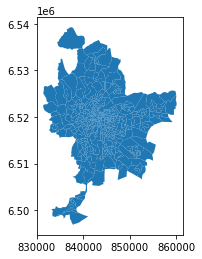

In [128]:
df_iris.plot()

In [129]:
def is_in_urban_area(df, x ,y):
    point = Point(849638.15,y)
    table = df.contains(point)
    for x in table:
        if x== True:
            return(True)
    return(False)

def commune_origin(df, x ,y):
    point = Point(x,y)
    table = df.contains(point)
    commune_name=""
    for i in range (len(table)):
        if table[i]== True:
            commune_name = df.loc[i, "commune_name"]
            break
    return commune_name

In [130]:
urban_cities = ["69381", "69382", "69383", "69384", "69385", "69386", "69387", "69388", "69389", "69266", "69029", "69256", "69034"]

In [131]:
df_iris_urban = df_iris[df_iris["commune_id"].isin(urban_cities)]

In [132]:
df_iris_urban

,iris_id,commune_name,commune_id,geometry
1,690290101,Bron,69029,"POLYGON ((848185.000 6517805.100, 848179.300 6..."
2,690290102,Bron,69029,"POLYGON ((848185.000 6517805.100, 848193.700 6..."
3,690290103,Bron,69029,"POLYGON ((848473.000 6517709.800, 848475.200 6..."
4,690290104,Bron,69029,"POLYGON ((849043.400 6517050.700, 849006.900 6..."
5,690290201,Bron,69029,"POLYGON ((848971.400 6517848.300, 848985.600 6..."
...,...,...,...,...
507,693890502,Lyon 9e Arrondissement,69389,"POLYGON ((839868.200 6520100.400, 839873.900 6..."
508,693890604,Lyon 9e Arrondissement,69389,"POLYGON ((839222.200 6522347.200, 839220.400 6..."
509,693890605,Lyon 9e Arrondissement,69389,"POLYGON ((839317.700 6522667.900, 839321.800 6..."
510,693890606,Lyon 9e Arrondissement,69389,"POLYGON ((839218.700 6521610.100, 839226.100 6..."


<AxesSubplot:>

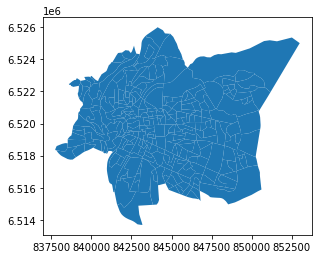

In [133]:
df_iris_urban.plot()

In [134]:
point = Point(849638.15,6517972.32)
table = df_iris_urban.contains(point)

In [135]:
table

1      False
2      False
3      False
4      False
5      False
       ...  
507    False
508    False
509    False
510    False
511    False
Length: 286, dtype: bool

In [136]:
df_iris_urban = df_iris_urban.reset_index() 

In [137]:
df_iris_urban

,index,iris_id,commune_name,commune_id,geometry
0,1,690290101,Bron,69029,"POLYGON ((848185.000 6517805.100, 848179.300 6..."
1,2,690290102,Bron,69029,"POLYGON ((848185.000 6517805.100, 848193.700 6..."
2,3,690290103,Bron,69029,"POLYGON ((848473.000 6517709.800, 848475.200 6..."
3,4,690290104,Bron,69029,"POLYGON ((849043.400 6517050.700, 849006.900 6..."
4,5,690290201,Bron,69029,"POLYGON ((848971.400 6517848.300, 848985.600 6..."
...,...,...,...,...,...
281,507,693890502,Lyon 9e Arrondissement,69389,"POLYGON ((839868.200 6520100.400, 839873.900 6..."
282,508,693890604,Lyon 9e Arrondissement,69389,"POLYGON ((839222.200 6522347.200, 839220.400 6..."
283,509,693890605,Lyon 9e Arrondissement,69389,"POLYGON ((839317.700 6522667.900, 839321.800 6..."
284,510,693890606,Lyon 9e Arrondissement,69389,"POLYGON ((839218.700 6521610.100, 839226.100 6..."


In [138]:
commune_origin(df_iris_urban, 849638.15, 6517972.32)

'Bron'

In [139]:
df_taxi_trips_1005159["commune_ori"] = df_taxi_trips_1005159.apply(lambda row: commune_origin(df_iris_urban, row.start_x, row.start_y), axis=1)

/tmp/ipykernel_207433/3289234011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_taxi_trips_1005159["commune_ori"] = df_taxi_trips_1005159.apply(lambda row: commune_origin(df_iris_urban, row.start_x, row.start_y), axis=1)


In [140]:
df_taxi_trips_1005159["commune_dest"] = df_taxi_trips_1005159.apply(lambda row: commune_origin(df_iris_urban, row.end_x, row.end_y), axis=1)

/tmp/ipykernel_207433/333688284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_taxi_trips_1005159["commune_dest"] = df_taxi_trips_1005159.apply(lambda row: commune_origin(df_iris_urban, row.end_x, row.end_y), axis=1)


In [141]:
df_taxi_trips_1005159.transpose()

,934,935
person,1005159,1005159
trip_number,1,2
trip_id,1005159_1,1005159_2
dep_time,07:21:05,15:21:05
trav_time,03:26:28,00:15:13
wait_time,03:17:28,00:04:43
traveled_distance,2247,2464
euclidean_distance,1658,1658
main_mode,NaN,NaN
longest_distance_mode,taxi,taxi


In [142]:
df_taxis = pd.read_csv("/media/aodiallo/Data/MATSIM/Simulation/robotaxi/input/taxis/df_taxis_15_p_cent_1916.csv")

In [143]:
df_taxis

,Unnamed: 0,index,nom,adresse,commune,nbemplacem,telephone,separateur,abri,panneau,diodes,totem,gid,geometry,link,link_id
0,0,58,TAX202,Centre d'Echange (domaine SNCF),Lyon 2 ème,61.0,Non,Peinture,Oui,Oui,Non,Non,59,POINT (841965.518102603 6518235.658134382),"LINESTRING (841961.874480692 6518209.38042021,...",85928
1,1,65,TAX300,Place Rouget de L'Isle,Lyon 3 ème,3.0,Non,Bordure granit,Non,Oui,Non,Non,66,POINT (845147.4245582524 6518913.846451514),LINESTRING (845161.153189008 6518944.164941258...,69978
2,2,56,TAX205,"26, Place Bellecour",Lyon 2 ème,3.0,Non,Peinture,Non,Oui,Non,Non,57,POINT (842350.1698133035 6519116.998928654),LINESTRING (842290.2276363085 6519136.86588886...,23614
3,3,54,TAX208,Place des Cordeliers,Lyon 2 ème,8.0,Non,Peinture,Non,Non,Non,Oui,55,POINT (842717.2470816755 6519879.5495876605),LINESTRING (842677.4276167355 6519864.82714292...,29452
4,4,99,TAXVIL05,"4, Avenue Henri Barbusse",VILLEURBANNE,5.0,Non,Bordure granit,Non,Oui,Non,Oui,100,POINT (846043.5140642242 6520598.639469579),LINESTRING (846044.0674782781 6520620.39496448...,26149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,2550,83,TAX600,"50, Quai Charles de Gaulle",Lyon 6 ème,6.0,Non,Peinture,Non,Oui,Non,Non,84,POINT (844060.0961684077 6522365.379025323),LINESTRING (844037.3864184965 6522365.61816107...,72139
2551,2551,90,TAX303,Vivier Merle,Lyon 3 ème,46.0,Non,Peinture,Oui,Oui,Non,Non,91,POINT (844461.0391917161 6519458.606494762),LINESTRING (844451.2013601443 6519368.27303986...,57735
2552,2552,11,TAX309,"67, Rue Servient",Lyon 3 ème,5.0,Non,Bordure granit,Non,Oui,Oui,Oui,12,POINT (843643.2505267737 6519550.809832772),LINESTRING (843701.7317494402 6519554.58774116...,28028
2553,2553,93,TAX708,Place Emir Abd El Kader,Lyon 7 ème,4.0,Non,Bordure granit,Non,Non,Non,Oui,94,POINT (843525.0576551789 6518641.972648442),LINESTRING (843507.8391424376 6518661.71128446...,1820


In [144]:
df_nb_taxis = df_taxis[["commune"]].groupby("commune").size().reset_index(name = "number_of_taxis")

In [145]:
df_nb_taxis

,commune,number_of_taxis
0,BRON,105
1,CALUIRE-ET-CUIRE,45
2,Lyon 1 er,49
3,Lyon 2 ème,609
4,Lyon 3 ème,699
5,Lyon 4 ème,60
6,Lyon 5 ème,105
7,Lyon 6 ème,252
8,Lyon 7 ème,231
9,Lyon 8 ème,77


In [146]:
df_trips_input_taxi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36787 entries, 0 to 354539
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    36787 non-null  int64  
 1   person_id                     36787 non-null  int64  
 2   departure_time                36787 non-null  object 
 3   arrival_time                  36787 non-null  object 
 4   mode                          36787 non-null  object 
 5   preceding_purpose             36787 non-null  object 
 6   from_x                        36787 non-null  float64
 7   from_y                        36787 non-null  float64
 8   preceding_purpose_start_time  26529 non-null  object 
 9   preceding_purpose_end_time    36787 non-null  object 
 10  following_purpose             36787 non-null  object 
 11  to_x                          36787 non-null  float64
 12  to_y                          36787 non-null  float64
 13  

In [147]:
df_trips_input_taxi["commune_ori"] = df_trips_input_taxi.apply(lambda row: commune_origin(df_iris_urban, row.from_x, row.from_y), axis=1)

/tmp/ipykernel_207433/3975493759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trips_input_taxi["commune_ori"] = df_trips_input_taxi.apply(lambda row: commune_origin(df_iris_urban, row.from_x, row.from_y), axis=1)


In [148]:
df_trips_input_taxi["commune_dest"] = df_trips_input_taxi.apply(lambda row: commune_origin(df_iris_urban, row.to_x, row.to_y), axis=1)

/tmp/ipykernel_207433/3602824775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trips_input_taxi["commune_dest"] = df_trips_input_taxi.apply(lambda row: commune_origin(df_iris_urban, row.to_x, row.to_y), axis=1)


In [149]:
df_nb_trips_taxi_commune_dest = df_trips_input_taxi[["commune_dest"]].groupby("commune_dest").size().reset_index(name = "number_of_trips_taxi")

In [150]:
df_nb_trips_taxi_commune_dest

,commune_dest,number_of_trips_taxi
0,,6042
1,Bron,2675
2,Caluire-et-Cuire,2693
3,Lyon 1er Arrondissement,831
4,Lyon 2e Arrondissement,1137
5,Lyon 3e Arrondissement,3800
6,Lyon 4e Arrondissement,1257
7,Lyon 5e Arrondissement,1555
8,Lyon 6e Arrondissement,1809
9,Lyon 7e Arrondissement,2459


In [151]:
df_nb_trips_taxi_commune_dest = df_trips_input_taxi[["commune_dest"]].groupby("commune_dest").size().reset_index(name = "number_of_trips_taxi")

**Quelques commentaires**
- L'agent 100428 n'a pu realiser l'activité (travail) dont le deplacement a été fait en taxi avec plus de 4h de temps d'attente avec un depart initial à 7h38. L'heure de fin de l'activité etant 11h38!  
- On note que le plan en sortie de la simulation n'a pas été modifié en consequence comparé au plan d'entrée intitial. 